# From Unstructured Emails to Explainable Predictions

This notebook implements the automated feature extraction, model training and active feature learning pipeline described in the paper.

## Pipeline Overview

The pipeline consists of seven stages:
1. **Feature Identification**: Extract initial feature schema from sample threads (Paper section 3.1)
2. **Semantic Clustering and Consolidation**: Reduce redundancy through clustering (Paper section 3.2)
3. **Feature Extraction**: Extract values for all emails under each thread (Paper section 3.3)
4. **Dataset Construction**: Build cumulative knowledge dataset with forward-filling (Paper section 3.4)
5. **Feature Correlation Analysis and Preprocessing**: Understanding feature relationships and removing redundant features 
6. **Binary Classification Models**: Train and evaluate gradient boosting decision trees (GBDT) and other classification models to predict whether a ticket should be created at an email point (Paper section 4.1)
7. **Active Feature Learning with SHAP**: Missing Feature Impact Assessment and Prediction Stability Check for confident predictions (Paper section 4.2 and 4.3)

## Setup and Dependencies

In [ ]:
# Install required packages
!pip install -U --quiet sentence-transformers hdbscan scikit-learn pandas numpy requests python-dotenv --upgrade


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import json
import os
import time
import requests
from typing import List, Dict, Any, Tuple
from collections import defaultdict
import numpy as np
import pandas as pd
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

True

## Model Setup with OpenRouter API

Initialize the LLM connection using OpenRouter API. We use the free Llama model "meta-llama/llama-4-maverick:free".

In [ ]:
# OpenRouter API Configuration
OPENROUTER_API_KEY = os.getenv("OPENROUTER_API_KEY")
MODEL_NAME = "meta-llama/llama-3.1-8b-instruct"
OPENROUTER_API_URL = "https://openrouter.ai/api/v1/chat/completions"

if not OPENROUTER_API_KEY:
    raise ValueError("OPENROUTER_API_KEY not found in environment variables. Please check your .env file.")

# Define generation parameters
GENERATION_PARAMS = {
    "temperature": 0.7,
    "top_p": 0.9,
    "max_tokens": 5000,
}

print(f"✓ OpenRouter API configured")
print(f"✓ Model: {MODEL_NAME}")
print(f"✓ Generation params: temperature={GENERATION_PARAMS['temperature']}, top_p={GENERATION_PARAMS['top_p']}")

✓ OpenRouter API configured
✓ Model: meta-llama/llama-3.1-8b-instruct
✓ Generation params: temperature=0.7, top_p=0.9


## Load Data

Load the preprocessed email threads with ticket information.

In [ ]:
# Load preprocessed tickets
DATA_PATH = "data/sample_email_threads.json"

with open(DATA_PATH, "r", encoding="utf-8") as f:
    data = json.load(f)

# Extract threads from the JSON structure
threads = data.get("threads", [])

print(f"Loaded {len(threads)} email threads")
if threads:
    print(f"Sample thread structure:")
    print(f"  - thread_id: {threads[0].get('thread_id')}")
    print(f"  - should_create_ticket: {threads[0].get('should_create_ticket')}")
    print(f"  - ticket: {threads[0].get('ticket', {}).get('name')}")
    print(f"  - emails count: {len(threads[0].get('emails', []))}")
    print(f"  - summary: {list(threads[0].get('summary', {}).keys())}")

Loaded 227 email threads
Sample thread structure:
  - thread_id: 1
  - should_create_ticket: True
  - ticket: Inventory Module Access Issue
  - emails count: 2
  - summary: ['issue_type', 'urgency', 'business_impact', 'technical_complexity', 'resolution_status']


## Stage 1: Feature Identification

- Take a sample of email threads E_sample ⊆ E
- Use primary LLM (Llama 3.1 8B Instruct) to identify features characterizing support interactions relevant to ticket creation decisions
- Produce an initial feature schema F_init
- Each feature f_k is a tuple: (name_k, type_k, desc_k, values_k)
  - name_k: feature identifier
  - type_k ∈ {categorical, numerical, boolean}
  - desc_k: semantic description
  - values_k: set of possible values for categorical features, or ∅ for numerical/boolean
- Use validation LLM (Qwen 2.5 7B Instruct) to validate identified features for each thread.

In [ ]:
def create_feature_identification_prompt(email_thread: str, ticket_name: str, ticket_description: str) -> str:
    """
    Create a prompt for feature identification as described in Section 3.1.

    The LLM receives both the email thread and corresponding ticket information,
    and identifies features relevant for deciding whether to create a support ticket.
    """
    prompt = f"""Analyze the following email thread along with its associated ticket details and identify features that would be relevant for deciding whether to create a support ticket of this type.

For each feature, provide:
1. name: A concise identifier (use snake_case)
2. type: One of "categorical", "numerical", or "boolean"
3. description: A clear semantic description of what the feature captures
4. values: For categorical features, provide a list of possible values. For numerical and boolean features, leave empty.

Ticket Information:
Name: {ticket_name}
Description: {ticket_description}

Email Thread:
{email_thread}

Return ONLY a valid JSON array with this exact structure:
[
  {{
    "name": "feature_name",
    "type": "categorical|numerical|boolean",
    "description": "What this feature represents",
    "values": ["value1", "value2"] or []
  }}
]

Focus on features that capture:
- Technical complexity and nature of the issue
- Urgency and business impact
- Multi-step resolution requirements
- Historical patterns and context
"""
    return prompt

In [ ]:
def call_llm_openrouter(prompt: str) -> str:
    """
    Call OpenRouter API for LLM generation.

    Args:
        prompt: The input prompt

    Returns:
        Generated text from the LLM
    """
    try:
        headers = {
            "Authorization": f"Bearer {OPENROUTER_API_KEY}",
            "Content-Type": "application/json",
            "HTTP-Referer": "https://github.com/furkanbk/unstructured-emails-to-explainable-predictions",
            "X-Title": "Email Feature Extraction"
        }

        payload = {
            "model": MODEL_NAME,
            "messages": [
                {
                    "role": "user",
                    "content": prompt
                }
            ],
            **GENERATION_PARAMS
        }

        response = requests.post(
            OPENROUTER_API_URL,
            headers=headers,
            json=payload,
            timeout=120
        )

        response.raise_for_status()

        result = response.json()

        # Extract the generated text from OpenRouter response
        if "choices" in result and len(result["choices"]) > 0:
            generated_text = result["choices"][0]["message"]["content"]
            return generated_text.strip()
        else:
            raise Exception("No content in OpenRouter API response")

    except requests.exceptions.RequestException as e:
        raise Exception(f"OpenRouter API request failed: {e}")
    except Exception as e:
        raise Exception(f"OpenRouter API generation failed: {e}")

In [ ]:
def format_email_thread(thread_data: Dict[str, Any]) -> str:
    """
    Format the email thread for the LLM prompt.

    Args:
        thread_data: Dictionary containing thread information with 'emails' array

    Returns:
        Formatted string representation of the email thread
    """
    email_flow = ""

    emails = thread_data.get("emails", [])

    for email in emails:
        email_flow += f"\n{'='*60}\n"
        email_flow += f"EMAIL {email.get('email_number', '?')}\n"
        email_flow += f"{'='*60}\n"
        email_flow += f"From: {email.get('sender_name', 'Unknown')} ({email.get('sender_email', 'N/A')})\n"
        email_flow += f"Sender Type: {email.get('sender', 'unknown')}\n"
        email_flow += f"Subject: {email.get('subject', 'No subject')}\n"
        email_flow += f"Time: {email.get('timestamp', 'unknown')}\n"
        email_flow += f"\nContent:\n{email.get('body', '')}\n"

    return email_flow

In [ ]:
def extract_json_from_response(response: str) -> List[Dict[str, Any]]:
    """
    Extract JSON array from LLM response.
    The LLM might wrap the JSON in markdown code blocks or add extra text.
    """
    import re

    # Try to find JSON array in code blocks
    json_match = re.search(r'```(?:json)?\s*([\s\S]*?)```', response)
    if json_match:
        response = json_match.group(1)

    # Try to find JSON array directly
    json_match = re.search(r'\[\s*\{[\s\S]*\}\s*\]', response)
    if json_match:
        response = json_match.group(0)

    try:
        return json.loads(response.strip())
    except json.JSONDecodeError as e:
        print(f"Failed to parse JSON: {e}")
        print(f"Response was: {response[:500]}...")
        return []

In [ ]:
def stage1_feature_identification(
    threads: List[Dict[str, Any]],
    sample_size: int = 100,
    save_path: str = "outputs/stage1_initial_features.json"
) -> List[Dict[str, Any]]:
    """
    Stage 1: Feature Identification (Section 3.1)

    Takes a sample of email threads and uses an LLM to identify features
    relevant for ticket creation decisions.

    Args:
        threads: List of email thread dictionaries
        sample_size: Number of threads to sample
        save_path: Path to save the results

    Returns: List of feature dictionaries forming the initial feature schema F_init
    """
    # Create output directory
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    # Sample threads (use first sample_size for reproducibility)
    sample_threads = threads[:min(sample_size, len(threads))]

    initial_features = []
    processed_count = 0

    print(f"Starting Stage 1: Feature Identification")
    print(f"Processing {len(sample_threads)} sample threads...\\n")

    for thread in sample_threads:
        processed_count += 1
        thread_id = thread.get("thread_id", f"unknown_{processed_count}")
        print(f"[{processed_count}/{len(sample_threads)}] Processing thread: {thread_id}")

        # Extract ticket information from the thread structure
        ticket_info = thread.get("ticket", {})
        ticket_name = ticket_info.get("name", "")
        ticket_description = ticket_info.get("description", "")

        # Format email thread
        email_thread = format_email_thread(thread)

        if not email_thread or not ticket_name:
            print(f"  ⚠️ Skipping thread {thread_id} - missing email thread or ticket name")
            continue

        # Create prompt
        prompt = create_feature_identification_prompt(email_thread, ticket_name, ticket_description)

        try:
            # Call LLM using OpenRouter API
            start_time = time.time()
            response = call_llm_openrouter(prompt)
            elapsed = time.time() - start_time

            # Parse response
            features = extract_json_from_response(response)

            if features:
                # Add source thread ID to each feature
                for feature in features:
                    feature["source_thread_id"] = thread_id
                initial_features.extend(features)

                print(f"  ✓ Extracted {len(features)} features ({elapsed:.2f}s)")
            else:
                print(f"  ⚠️ No features extracted")

            # Save progress every 10 threads
            if processed_count % 10 == 0:
                with open(save_path, "w", encoding="utf-8") as f:
                    json.dump(initial_features, f, indent=2, ensure_ascii=False)
                print(f"  💾 Progress saved ({len(initial_features)} features so far)\\n")

        except Exception as e:
            print(f"  ❌ Error processing thread {thread_id}: {e}")
            continue

    # Final save
    with open(save_path, "w", encoding="utf-8") as f:
        json.dump(initial_features, f, indent=2, ensure_ascii=False)

    print(f"\\n{'='*60}")
    print(f"Stage 1 Complete!")
    print(f"Total features identified: {len(initial_features)}")
    print(f"Saved to: {save_path}")
    print(f"{'='*60}\\n")

    return initial_features

In [ ]:
# Run Stage 1
# Make sure the OpenRouter API key is set in .env before running this

initial_features = stage1_feature_identification(
    threads=threads,
    sample_size=30,  # Using sample threads as mentioned in the paper
    save_path="outputs/stage1_initial_features.json"
)

Starting Stage 1: Feature Identification
Processing 30 sample threads...\n
[1/30] Processing thread: 1
  ✓ Extracted 9 features (14.17s)
[2/30] Processing thread: 2
  ✓ Extracted 8 features (12.60s)
[3/30] Processing thread: 3
  ✓ Extracted 8 features (46.06s)
[4/30] Processing thread: 4
Failed to parse JSON: Expecting value: line 1 column 1 (char 0)
Response was: Here is the list of features that can be extracted from the email thread:

1. **ticket_category**
  type: categorical
  description: The type of issue reported (e.g. payment, security, performance, etc.)
  values: ["payment", "security", "performance", etc.]

2. **incident_impact**
  type: categorical
  description: The business impact of the issue (e.g. revenue loss, downtime, data loss, etc.)
  values: ["revenue_loss", "downtime", "data_loss", "other"]

3. **issue_severity**
  type: categorica...
  ⚠️ No features extracted
[5/30] Processing thread: 5
  ✓ Extracted 9 features (6.89s)
[6/30] Processing thread: 6
  ✓ Extracted

In [ ]:
# Analyze the initial features
if initial_features:
    # Count by type
    type_counts = defaultdict(int)
    for feature in initial_features:
        type_counts[feature.get("type", "unknown")] += 1

    print("Feature Type Distribution:")
    for ftype, count in sorted(type_counts.items()):
        print(f"  {ftype}: {count}")

    # Show sample features
    print("\nSample Features:")
    for i, feature in enumerate(initial_features[:5], 1):
        print(f"\n{i}. {feature.get('name', 'N/A')}")
        print(f"   Type: {feature.get('type', 'N/A')}")
        print(f"   Description: {feature.get('description', 'N/A')}")
        if feature.get('values'):
            print(f"   Values: {feature.get('values')}")

Feature Type Distribution:
  boolean: 66
  categorical: 174
  numerical: 39

Sample Features:

1. error_type
   Type: categorical
   Description: The type of error encountered by the customer
   Values: ['database_connection_failed', 'unknown', 'other']

2. crm_version
   Type: categorical
   Description: The version of the CRM system being used
   Values: ['4.2.1', '4.2.0', '4.1.9', 'other']

3. os_type
   Type: categorical
   Description: The type of operating system being used by the customer
   Values: ['windows_10', 'windows_11', 'linux', 'macos']

4. reboot_status
   Type: boolean
   Description: Whether the customer has tried rebooting their system

5. cache_clear_status
   Type: boolean
   Description: Whether the customer has tried clearing the cache


### Validation: Qwen 2.5 7B Instruct

We use **Qwen 2.5 7B Instruct as a validation model** to improve feature extraction reliability. The validation mechanism works as follows:

**Two-Phase Approach:**

1. **Phase 1 - Primary Extraction** (Already completed in Cell 16):
   - Llama 3.1 8B Instruct extracts initial features from sample email threads
   - Features saved to `outputs/stage1_initial_features.json`

2. **Phase 2 - Batch Validation** (Implemented below):
   - Load existing features from Phase 1
   - Group features by thread_id
   - For each thread, send ALL its features to Qwen 2.5 7B along with ticket context
   - Validation model filters out hallucinated, irrelevant, or poorly-defined features
   - Save validated features to `outputs/stage1_initial_features_validated.json`

This dual-model approach helps reduce hallucinations and improves the quality of the initial feature schema F_init.

In [ ]:
# Validation Model Configuration
VALIDATION_MODEL_NAME = "qwen/qwen-2.5-7b-instruct"

print(f"✓ Validation model configured")
print(f"✓ Primary model: {MODEL_NAME}")
print(f"✓ Validation model: {VALIDATION_MODEL_NAME}")

✓ Validation model configured
✓ Primary model: meta-llama/llama-3.1-8b-instruct
✓ Validation model: qwen/qwen-2.5-7b-instruct


In [ ]:
def create_validation_prompt(email_thread: str, ticket_name: str, ticket_description: str, extracted_features: List[Dict[str, Any]]) -> str:
    """
    Create a batch validation prompt for Qwen 2.5 7B Instruct.

    The validation model reviews ALL features extracted from a single thread
    and filters out invalid ones.

    Args:
        email_thread: Formatted email thread text
        ticket_name: Ticket name
        ticket_description: Ticket description
        extracted_features: All features extracted from this thread by primary model

    Returns:
        Validation prompt string
    """
    features_json = json.dumps(extracted_features, indent=2)

    prompt = f"""You are a validation model reviewing features extracted for ticket creation decision-making.

TASK: Review the following features that were extracted from a single email thread by another model. Filter this list to keep only VALID features.

Ticket Information:
Name: {ticket_name}
Description: {ticket_description}

Email Thread:
{email_thread}

Extracted Features to Validate:
{features_json}

VALIDATION CRITERIA - A feature is VALID if it:
1. Is relevant for ticket creation decisions
2. Has a clear and accurate description
3. Is extractable from the email context provided
4. Is not redundant or duplicate
5. Has appropriate type and values defined

VALIDATION CRITERIA - A feature is INVALID if it:
1. Is irrelevant to ticket creation decisions
2. Has ambiguous or incorrect description
3. Cannot be determined from the email context
4. Is a duplicate of another feature
5. Has incorrect type or poorly defined values

Return ONLY a JSON array containing the VALID features (keeping their exact original structure):
[
  {{
    "name": "feature_name",
    "type": "categorical|numerical|boolean",
    "description": "description",
    "values": ["value1", "value2"] or []
  }}
]

If ALL features are invalid, return an empty array: []
Only include features that clearly meet the validation criteria.
"""
    return prompt

In [ ]:
def call_validation_model(prompt: str) -> str:
    """
    Call Qwen 2.5 7B Instruct validation model via OpenRouter API.

    Args:
        prompt: The validation prompt

    Returns:
        Generated text from the validation model
    """
    try:
        headers = {
            "Authorization": f"Bearer {OPENROUTER_API_KEY}",
            "Content-Type": "application/json",
            "HTTP-Referer": "https://github.com/furkanbk/unstructured-emails-to-explainable-predictions",
            "X-Title": "Email Feature Validation"
        }

        payload = {
            "model": VALIDATION_MODEL_NAME,  # Use Qwen 2.5 7B Instruct
            "messages": [
                {
                    "role": "user",
                    "content": prompt
                }
            ],
            "temperature": 0.3,  # Lower temperature for validation (more conservative)
            "top_p": 0.9,
            "max_tokens": 5000
        }

        response = requests.post(
            OPENROUTER_API_URL,
            headers=headers,
            json=payload,
            timeout=120
        )

        response.raise_for_status()

        result = response.json()

        # Extract the generated text from OpenRouter response
        if "choices" in result and len(result["choices"]) > 0:
            generated_text = result["choices"][0]["message"]["content"]
            return generated_text.strip()
        else:
            raise Exception("No content in validation model response")

    except requests.exceptions.RequestException as e:
        raise Exception(f"Validation model API request failed: {e}")
    except Exception as e:
        raise Exception(f"Validation model generation failed: {e}")

In [ ]:
def validate_existing_features(
    features_by_thread: Dict[str, List[Dict[str, Any]]],
    threads: List[Dict[str, Any]],
    save_path: str = "outputs/stage1_initial_features_validated.json"
) -> Tuple[List[Dict[str, Any]], Dict[str, Any]]:
    """
    Validate already-extracted features using Qwen 2.5 7B Instruct.

    This function takes features that were already extracted by the primary model
    (Llama 3.1 8B) and validates them in batch per thread using Qwen 2.5 7B.

    Args:
        features_by_thread: Dictionary mapping thread_id to list of features
        threads: List of thread dictionaries (to get ticket info)
        save_path: Path to save validated features

    Returns:
        Tuple of (validated_features_list, statistics)
    """
    # Create thread lookup for ticket info
    thread_lookup = {str(t.get("thread_id")): t for t in threads}

    validated_features = []
    overall_stats = {
        "threads_processed": 0,
        "threads_successful": 0,
        "total_primary_features": 0,
        "total_validated_features": 0,
        "total_filtered_features": 0
    }

    print(f"Starting Batch Validation with Qwen 2.5 7B Instruct")
    print(f"Validation Model: {VALIDATION_MODEL_NAME}")
    print(f"Threads to validate: {len(features_by_thread)}\\n")

    for idx, (thread_id, thread_features) in enumerate(features_by_thread.items(), 1):
        print(f"[{idx}/{len(features_by_thread)}] Validating thread: {thread_id}")
        print(f"  Primary features: {len(thread_features)}")

        # Get thread info
        thread_data = thread_lookup.get(str(thread_id))
        if not thread_data:
            print(f"  ⚠️ Thread data not found, skipping")
            overall_stats["threads_processed"] += 1
            continue

        # Extract ticket information
        ticket_info = thread_data.get("ticket", {})
        ticket_name = ticket_info.get("name", "")
        ticket_description = ticket_info.get("description", "")

        # Format email thread for context
        email_thread = format_email_thread(thread_data)

        if not email_thread or not ticket_name:
            print(f"  ⚠️ Missing email thread or ticket name, skipping")
            overall_stats["threads_processed"] += 1
            continue

        try:
            # Create validation prompt with all features from this thread
            validation_prompt = create_validation_prompt(
                email_thread, ticket_name, ticket_description, thread_features
            )

            # Call validation model
            start_time = time.time()
            validation_response = call_validation_model(validation_prompt)
            validation_elapsed = time.time() - start_time

            # Parse validated features
            thread_validated_features = extract_json_from_response(validation_response)

            if thread_validated_features:
                # Add metadata to validated features
                for feature in thread_validated_features:
                    feature["source_thread_id"] = thread_id
                    feature["validated"] = True

                validated_features.extend(thread_validated_features)

                # Update statistics
                filtered_count = len(thread_features) - len(thread_validated_features)
                overall_stats["total_primary_features"] += len(thread_features)
                overall_stats["total_validated_features"] += len(thread_validated_features)
                overall_stats["total_filtered_features"] += filtered_count
                overall_stats["threads_successful"] += 1

                print(f"  ✓ Validated {len(thread_validated_features)}/{len(thread_features)} features ({validation_elapsed:.2f}s)")
                if filtered_count > 0:
                    print(f"    → Filtered {filtered_count} features")
            else:
                print(f"  ⚠️ No features validated, using fallback")
                # Fallback to original features
                for feature in thread_features:
                    feature["validated"] = False
                validated_features.extend(thread_features)
                overall_stats["total_primary_features"] += len(thread_features)
                overall_stats["total_validated_features"] += len(thread_features)

        except Exception as e:
            print(f"  ❌ Validation error: {e}")
            print(f"  ⚠️ Using fallback features")
            # Fallback to original features
            for feature in thread_features:
                feature["validated"] = False
            validated_features.extend(thread_features)
            overall_stats["total_primary_features"] += len(thread_features)
            overall_stats["total_validated_features"] += len(thread_features)

        finally:
            overall_stats["threads_processed"] += 1

        # Save progress every 10 threads
        if idx % 10 == 0:
            with open(save_path, "w", encoding="utf-8") as f:
                json.dump({
                    "features": validated_features,
                    "statistics": overall_stats
                }, f, indent=2, ensure_ascii=False)
            print(f"  💾 Progress saved ({len(validated_features)} features so far)\\n")

    # Final save
    with open(save_path, "w", encoding="utf-8") as f:
        json.dump({
            "features": validated_features,
            "statistics": overall_stats
        }, f, indent=2, ensure_ascii=False)

    print(f"\\n{'='*60}")
    print(f"Batch Validation Complete!")
    print(f"Threads processed: {overall_stats['threads_processed']}")
    print(f"Threads successful: {overall_stats['threads_successful']}")
    print(f"Primary features: {overall_stats['total_primary_features']}")
    print(f"Validated features: {overall_stats['total_validated_features']}")
    print(f"Filtered features: {overall_stats['total_filtered_features']}")
    if overall_stats['total_primary_features'] > 0:
        filter_rate = (overall_stats['total_filtered_features'] / overall_stats['total_primary_features']) * 100
        print(f"Filter rate: {filter_rate:.1f}%")
    print(f"Saved to: {save_path}")
    print(f"{'='*60}\\n")

    return validated_features, overall_stats

In [ ]:
# Run batch validation on existing features
# Load the features that were already extracted by the primary model

print("Loading existing features from stage1_initial_features.json...")
with open("outputs/stage1_initial_features.json", "r", encoding="utf-8") as f:
    existing_features = json.load(f)

print(f"Loaded {len(existing_features)} features from primary extraction\\n")

# Group features by thread_id
features_by_thread = defaultdict(list)
for feature in existing_features:
    thread_id = feature.get("source_thread_id", "unknown")
    features_by_thread[thread_id].append(feature)

print(f"Features grouped into {len(features_by_thread)} threads")
print(f"\\nThread feature counts:")
for thread_id, feats in list(features_by_thread.items())[:5]:
    print(f"  Thread {thread_id}: {len(feats)} features")
print(f"  ... ({len(features_by_thread) - 5} more threads)\\n")

# Run validation
validated_features, validation_stats = validate_existing_features(
    features_by_thread=features_by_thread,
    threads=threads,
    save_path="outputs/stage1_initial_features_validated.json"
)

Loading existing features from stage1_initial_features.json...
Loaded 279 features from primary extraction\n
Features grouped into 29 threads
\nThread feature counts:
  Thread 1: 9 features
  Thread 2: 8 features
  Thread 3: 8 features
  Thread 5: 9 features
  Thread 6: 10 features
  ... (24 more threads)\n
Starting Batch Validation with Qwen 2.5 7B Instruct
Validation Model: qwen/qwen-2.5-7b-instruct
Threads to validate: 29\n
[1/29] Validating thread: 1
  Primary features: 9
  ✓ Validated 7/9 features (7.92s)
    → Filtered 2 features
[2/29] Validating thread: 2
  Primary features: 8
  ✓ Validated 4/8 features (4.87s)
    → Filtered 4 features
[3/29] Validating thread: 3
  Primary features: 8
  ✓ Validated 5/8 features (6.98s)
    → Filtered 3 features
[4/29] Validating thread: 5
  Primary features: 9
  ✓ Validated 5/9 features (7.39s)
    → Filtered 4 features
[5/29] Validating thread: 6
  Primary features: 10
  ✓ Validated 7/10 features (9.06s)
    → Filtered 3 features
[6/29] Valid

In [ ]:
# Compare primary extraction vs validated features
if validated_features:
    print("\\n" + "="*60)
    print("VALIDATION ANALYSIS: PRIMARY vs VALIDATED FEATURES")
    print("="*60)

    # Load original features for comparison
    with open("outputs/stage1_initial_features.json", "r", encoding="utf-8") as f:
        original_features = json.load(f)

    print(f"\\n📊 Overall Statistics:")
    print(f"  Original features (primary): {len(original_features)}")
    print(f"  Validated features: {len(validated_features)}")
    print(f"  Filtered out: {len(original_features) - len(validated_features)}")
    if len(original_features) > 0:
        filter_rate = ((len(original_features) - len(validated_features)) / len(original_features)) * 100
        print(f"  Filter rate: {filter_rate:.1f}%")

    # Count validated vs fallback
    validated_count = sum(1 for f in validated_features if f.get("validated", False))
    fallback_count = len(validated_features) - validated_count

    print(f"\\n✓ Validation Status:")
    print(f"  Successfully validated: {validated_count}")
    print(f"  Fallback (validation failed): {fallback_count}")

    # Type distribution comparison
    print(f"\\n📋 Feature Type Distribution:")

    original_types = defaultdict(int)
    validated_types = defaultdict(int)

    for f in original_features:
        original_types[f.get("type", "unknown")] += 1

    for f in validated_features:
        validated_types[f.get("type", "unknown")] += 1

    all_types = set(original_types.keys()) | set(validated_types.keys())

    print(f"  {'Type':<15} {'Original':<10} {'Validated':<10} {'Filtered':<10}")
    print(f"  {'-'*50}")
    for ftype in sorted(all_types):
        orig_count = original_types[ftype]
        val_count = validated_types[ftype]
        filtered = orig_count - val_count
        print(f"  {ftype:<15} {orig_count:<10} {val_count:<10} {filtered:<10}")

    # Show examples of filtered features
    print(f"\\n🗑️ Examples of Filtered Features:")
    original_names = {f["name"] for f in original_features}
    validated_names = {f["name"] for f in validated_features if f.get("validated", False)}
    filtered_names = original_names - validated_names

    for i, name in enumerate(list(filtered_names)[:5], 1):
        # Find the full feature
        filtered_feature = next((f for f in original_features if f["name"] == name), None)
        if filtered_feature:
            print(f"  {i}. {name}")
            print(f"     Type: {filtered_feature.get('type', 'N/A')}")
            print(f"     Description: {filtered_feature.get('description', 'N/A')[:80]}...")

    # Show examples of validated features
    print(f"\\n✅ Examples of Validated Features:")
    validated_samples = [f for f in validated_features if f.get("validated", False)][:5]
    for i, feature in enumerate(validated_samples, 1):
        print(f"  {i}. {feature.get('name', 'N/A')}")
        print(f"     Type: {feature.get('type', 'N/A')}")
        print(f"     Description: {feature.get('description', 'N/A')[:80]}...")
        if feature.get('values'):
            print(f"     Sample values: {feature.get('values')[:3]}")

    print(f"\\n{'='*60}")

\n============================================================
VALIDATION ANALYSIS
\nValidated features: 41
Non-validated features (fallback): 0
\nFeature Type Distribution:
  boolean: 12
  categorical: 24
  numerical: 5
\nSample Validated Features:
\n1. error_message_category
   Type: categorical
   Description: The category of the error message
   Validated: ✓
   Values: ['database_connection_failure', 'unknown']
\n2. crm_version
   Type: numerical
   Description: The version of the CRM system
   Validated: ✓
\n3. system_os
   Type: categorical
   Description: The operating system of the machine
   Validated: ✓
   Values: ['windows', 'linux', 'macos']


## Stage 2: Semantic Clustering and Consolidation

- Use sentence embeddings to map features to dense vectors based on name and description
- Apply HDBSCAN clustering to identify semantically similar features
- Domain expert reviews and consolidates features within each cluster
- Reduces F_init (potentially hundreds of features) to F* (manageable set)

In [ ]:
# Load validated features from Stage 1 for Stage 2 clustering
# The validated JSON has structure: {"features": [...], "statistics": {...}}

with open("outputs/stage1_initial_features_validated.json", "r", encoding="utf-8") as f:
    validated_data = json.load(f)

# Extract the features list from the JSON structure
initial_features = validated_data["features"]
validation_statistics = validated_data.get("statistics", {})

print(f"Loaded {len(initial_features)} validated features from Stage 1")
print(f"Type: {type(initial_features)}")
print(f"\\nValidation Statistics:")
for key, value in validation_statistics.items():
    print(f"  {key}: {value}")

if initial_features:
    print(f"\\nSample feature structure: {list(initial_features[0].keys())}")
    print(f"\\nFirst feature example:")
    print(f"  Name: {initial_features[0].get('name')}")
    print(f"  Type: {initial_features[0].get('type')}")
    print(f"  Description: {initial_features[0].get('description')}")
    print(f"  Validated: {initial_features[0].get('validated', 'N/A')}")

In [ ]:
!pip install sentence_transformers
!pip install ipywidgets



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


   ---------------------------------------- 0.0/139.8 kB ? eta -:--:--
   ----------------- ---------------------- 61.4/139.8 kB 1.7 MB/s eta 0:00:01
   -------------------------------------- - 133.1/139.8 kB 2.6 MB/s eta 0:00:01
   ---------------------------------------- 139.8/139.8 kB 1.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/914.9 kB ? eta -:--:--
   ----- ---------------------------------- 122.9/914.9 kB 3.5 MB/s eta 0:00:01
   ----------- ---------------------------- 256.0/914.9 kB 3.1 MB/s eta 0:00:01
   ---------------- ----------------------- 368.6/914.9 kB 2.9 MB/s eta 0:00:01
   --------------------- ------------------ 491.5/914.9 kB 2.8 MB/s eta 0:00:01
   --------------------------- ------------ 624.6/914.9 kB 3.0 MB/s eta 0:00:01
   --------------------------------- ------ 757.8/914.9 kB 3.0 MB/s eta 0:00:01
   -------------------------------------- - 870.4/914.9 kB 2.9 MB/s eta 0:00:01
   ---------------------------------------  911.4/914.9 kB 

ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'C:\\Users\\kocak\\Desktop\\Thesis Paper\\unstructured-emails-to-explainable-predictions\\venv\\share\\jupyter\\labextensions\\@jupyter-widgets\\jupyterlab-manager\\static\\vendors-node_modules_base64-js_index_js-node_modules_sanitize-html_index_js.c79fc2bcc3f69676beda.js.map'
HINT: This error might have occurred since this system does not have Windows Long Path support enabled. You can find information on how to enable this at https://pip.pypa.io/warnings/enable-long-paths


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
!pip install hdbscan


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
!pip install matplotlib


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# Load sentence transformer model for embeddings
from sentence_transformers import SentenceTransformer

embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
print(f"✓ Sentence transformer model loaded")
print(f"✓ Model: all-MiniLM-L6-v2")
print(f"✓ Embedding dimension: {embedding_model.get_sentence_embedding_dimension()}")

✓ Sentence transformer model loaded
✓ Model: all-MiniLM-L6-v2
✓ Embedding dimension: 384


In [ ]:
import numpy as np
def create_feature_embedding_text(feature: Dict[str, Any]) -> str:
    """
    Create text representation of feature for embedding.
    Concatenates name and description as per Section 3.2.

    Args:
        feature: Feature dictionary with 'name' and 'description'

    Returns:
        Text string for embedding
    """
    name = feature.get("name", "")
    description = feature.get("description", "")

    # Concatenate name and description
    return f"{name}: {description}"


def compute_feature_embeddings(features: List[Dict[str, Any]]) -> np.ndarray:
    """
    Compute sentence embeddings for features.

    ψ: f_k → e_k ∈ R^d

    Args:
        features: List of feature dictionaries

    Returns:
        Array of embeddings with shape (n_features, embedding_dim)
    """
    # Create text representations
    feature_texts = [create_feature_embedding_text(f) for f in features]

    # Compute embeddings
    embeddings = embedding_model.encode(feature_texts, show_progress_bar=True)

    return embeddings

In [ ]:
import hdbscan
from sklearn.metrics.pairwise import cosine_similarity
def cluster_features_hdbscan(
    embeddings: np.ndarray,
    min_cluster_size: int = 2,
    min_samples: int = 1,
    #cluster_selection_epsilon: float = 0.5
) -> Tuple[np.ndarray, hdbscan.HDBSCAN]:
    """
    Apply HDBSCAN clustering to feature embeddings.

    C = HDBSCAN({e_1, ..., e_m}, ε, min_samples)

    Args:
        embeddings: Feature embeddings matrix
        min_cluster_size: Minimum cluster size for HDBSCAN
        min_samples: Minimum samples for core points
        metric: Distance metric to use

    Returns:
        Tuple of (cluster_labels, clusterer)
        - cluster_labels: Array of cluster assignments (-1 for noise)
        - clusterer: Fitted HDBSCAN object
    """
    #compute precomputed cosine similarity matrix
    sim = cosine_similarity(embeddings)

        # 2. Convert similarity → distance = 1 - sim
    dist = 1 - sim.astype(np.float64)
    metric = 'precomputed'
    data = dist
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=min_cluster_size,
        min_samples=min_samples,
        metric=metric,
        #cluster_selection_epsilon=cluster_selection_epsilon,
        cluster_selection_method='eom'  # Excess of Mass
    )

    cluster_labels = clusterer.fit_predict(data)

    return cluster_labels, clusterer

In [ ]:
def consolidate_cluster(
    cluster_features: List[Dict[str, Any]],
    cluster_id: int
) -> Dict[str, Any]:
    """
    Consolidate features within a cluster into a single representative feature.

    For each cluster C_j, select or create f*_j.

    This simulates domain expert consolidation by:
    1. Using the most common feature name
    2. Creating a comprehensive description
    3. Merging categorical values
    4. Preferring the most common type

    Args:
        cluster_features: List of features in the cluster
        cluster_id: Cluster identifier

    Returns:
        Consolidated feature dictionary
    """
    if not cluster_features:
        return None

    # If cluster has only one feature, return it as-is
    if len(cluster_features) == 1:
        return cluster_features[0].copy()

    # Count feature types
    type_counts = defaultdict(int)
    for f in cluster_features:
        type_counts[f.get("type", "categorical")] += 1

    # Select most common type
    consolidated_type = max(type_counts.items(), key=lambda x: x[1])[0]

    # For categorical features, merge all possible values
    consolidated_values = []
    if consolidated_type == "categorical":
        value_set = set()
        for f in cluster_features:
            values = f.get("values", [])
            if values:
                value_set.update(values)
        consolidated_values = sorted([str(v) for v in value_set])

    # Use the most common name pattern (extract root name)
    names = [f.get("name", "") for f in cluster_features]
    # Use the shortest name as it's often the most concise
    consolidated_name = min(names, key=len) if names else f"consolidated_feature_{cluster_id}"

    # Create comprehensive description
    descriptions = [f.get("description", "") for f in cluster_features]
    # Use the longest description as it's often most comprehensive
    consolidated_description = max(descriptions, key=len) if descriptions else f"Consolidated from {len(cluster_features)} features"

    # Build consolidated feature
    consolidated_feature = {
        "name": consolidated_name,
        "type": consolidated_type,
        "description": consolidated_description,
        "values": consolidated_values,
        "cluster_id": cluster_id,
        "source_features": len(cluster_features),
        "original_names": names
    }

    return consolidated_feature

In [ ]:
# Read initial features from Stage 1 output
# Load as a list of dictionaries, NOT as a pandas DataFrame

with open("outputs/stage1_initial_features_validated.json", "r", encoding="utf-8") as f:
    initial_features = json.load(f)

print(f"Loaded {len(initial_features)} initial features from Stage 1")
print(f"Type: {type(initial_features)}")
if initial_features:
    print("Sample feature structure:")
    print(list(initial_features.get("features")[0].keys()))

Loaded 2 initial features from Stage 1
Type: <class 'dict'>
Sample feature structure:
['name', 'type', 'description', 'values', 'source_thread_id', 'validated']


In [ ]:
import numpy as np

def convert_numpy(obj):
    if isinstance(obj, dict):
        return {k: convert_numpy(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_numpy(v) for v in obj]
    elif isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    else:
        return obj


In [ ]:
def stage2_semantic_clustering_consolidation(
    initial_features: List[Dict[str, Any]],
    min_cluster_size: int = 2,
    min_samples: int = 1,
    save_path: str = "outputs/stage2_consolidated_features.json",
    save_clusters_path: str = "outputs/stage2_clusters_analysis.json"
) -> Tuple[List[Dict[str, Any]], Dict[str, Any]]:
    """
    Stage 2: Semantic Clustering and Consolidation (Section 3.2)

    Consolidates the initial feature schema F_init into a smaller consolidated schema F*.

    Process:
    1. Compute embeddings: ψ: f_k → e_k ∈ R^d
    2. Apply HDBSCAN clustering: C = HDBSCAN({e_1, ..., e_m})
    3. Consolidate each cluster: C_j → f*_j
    4. Post-process and create F*

    Args:
        initial_features: Initial feature schema F_init
        min_cluster_size: Minimum cluster size for HDBSCAN
        min_samples: Minimum samples for HDBSCAN
        save_path: Path to save consolidated features
        save_clusters_path: Path to save clustering analysis

    Returns:
        Tuple of (consolidated_features, clustering_info)
    """
    print(f"Starting Stage 2: Semantic Clustering and Consolidation")
    print(f"Initial feature count: {len(initial_features)}\\n")

    # Step 1: Compute embeddings
    print("Step 1: Computing feature embeddings...")
    embeddings = compute_feature_embeddings(initial_features)
    print(f"✓ Computed {len(embeddings)} embeddings of dimension {embeddings.shape[1]}\\n")

    # Step 2: Apply HDBSCAN clustering
    print("Step 2: Applying HDBSCAN clustering...")
    cluster_labels, clusterer = cluster_features_hdbscan(
        embeddings,
        min_cluster_size=min_cluster_size,
        min_samples=min_samples
    )

    n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
    n_noise = list(cluster_labels).count(-1)

    print(f"✓ Identified {n_clusters} clusters")
    print(f"✓ Noise points (unclustered): {n_noise}\\n")

    # Step 3: Consolidate features
    print("Step 3: Consolidating features within clusters...")

    # Group features by cluster
    clusters = defaultdict(list)
    for idx, label in enumerate(cluster_labels):
        clusters[label].append(initial_features[idx])

    # Consolidate each cluster
    consolidated_features = []
    clustering_info = {
        "n_initial_features": len(initial_features),
        "n_clusters": n_clusters,
        "n_noise_points": n_noise,
        "clusters": []
    }

    for cluster_id, cluster_features in sorted(clusters.items()):
        if cluster_id == -1:
            # Noise points - keep them as individual features
            for feature in cluster_features:
                feature_copy = feature.copy()
                feature_copy["cluster_id"] = -1
                feature_copy["source_features"] = 1
                consolidated_features.append(feature_copy)

            clustering_info["clusters"].append({
                "cluster_id": -1,
                "size": len(cluster_features),
                "type": "noise",
                "features": [f.get("name") for f in cluster_features]
            })
        else:
            # Regular cluster - consolidate
            consolidated = consolidate_cluster(cluster_features, cluster_id)
            if consolidated:
                consolidated_features.append(consolidated)

                clustering_info["clusters"].append({
                    "cluster_id": int(cluster_id),
                    "size": len(cluster_features),
                    "type": "consolidated",
                    "consolidated_name": consolidated.get("name"),
                    "original_names": consolidated.get("original_names", []),
                    "feature_type": consolidated.get("type")
                })

                print(f"  Cluster {cluster_id}: {len(cluster_features)} features → '{consolidated.get('name')}'")

    print(f"\\n✓ Consolidated to {len(consolidated_features)} features")
    print(f"  Reduction: {len(initial_features)} → {len(consolidated_features)} ({100*(1-len(consolidated_features)/len(initial_features)):.1f}% reduction)\\n")

    # Save results
    clustering_info["n_consolidated_features"] = len(consolidated_features)
    clustering_info["reduction_percentage"] = 100 * (1 - len(consolidated_features) / len(initial_features))

    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    print(consolidated_features)
    print(clustering_info)
    with open(save_path, "w", encoding="utf-8") as f:
        json.dump(convert_numpy(consolidated_features), f, indent=2, ensure_ascii=False)

    with open(save_clusters_path, "w", encoding="utf-8") as f:
        json.dump(clustering_info, f, indent=2, ensure_ascii=False)

    print(f"{'='*60}")
    print(f"Stage 2 Complete!")
    print(f"Consolidated features saved to: {save_path}")
    print(f"Clustering analysis saved to: {save_clusters_path}")
    print(f"{'='*60}\\n")

    return consolidated_features, clustering_info

In [ ]:
# Run Stage 2: Semantic Clustering and Consolidation
# Use the correctly loaded initial_features (list of dicts, not DataFrame)

consolidated_features, clustering_info = stage2_semantic_clustering_consolidation(
    initial_features=initial_features.get("features"),
    min_cluster_size=2,  # Minimum 2 features to form a cluster
    min_samples=1,       # Allow clusters with just 1 core sample
    save_path="outputs/stage2_consolidated_features.json",
    save_clusters_path="outputs/stage2_clusters_analysis.json"
)

Starting Stage 2: Semantic Clustering and Consolidation
Initial feature count: 187\n
Step 1: Computing feature embeddings...


Batches: 100%|██████████| 6/6 [00:00<00:00, 18.07it/s]

✓ Computed 187 embeddings of dimension 384\n
Step 2: Applying HDBSCAN clustering...
✓ Identified 47 clusters
✓ Noise points (unclustered): 56\n
Step 3: Consolidating features within clusters...
  Cluster 0: 5 features → 'database_health_check'
  Cluster 1: 2 features → 'rollback_status'
  Cluster 2: 2 features → 'ticket_id'
  Cluster 3: 2 features → 'cache_clear_status'
  Cluster 4: 2 features → 'reboot_status'
  Cluster 5: 3 features → 'historical_pattern'
  Cluster 6: 4 features → 'resolution_options'
  Cluster 7: 3 features → 'device_consistency'
  Cluster 8: 2 features → 'browser_type'
  Cluster 9: 4 features → 'repeated_issue'
  Cluster 10: 3 features → 'os_type'
  Cluster 11: 2 features → 'upgrade_related'
  Cluster 12: 2 features → 'user_impact'
  Cluster 13: 3 features → 'escalation_needed'
  Cluster 14: 2 features → 'system_change'
  Cluster 15: 5 features → 'recent_update'
  Cluster 16: 4 features → 'technical_complexity'
  Cluster 17: 2 features → 'escalation_required'
  Clu

In [ ]:
# Analyze the consolidated features

print("\\n" + "="*60)
print("Consolidated Feature Schema F*")
print("="*60)
print(f"Total features in F*: {len(consolidated_features)}\\n")

# Count by type
type_counts = defaultdict(int)
for feature in consolidated_features:
    type_counts[feature.get("type", "unknown")] += 1

print("Feature Type Distribution in F*:")
for ftype, count in sorted(type_counts.items()):
    print(f"  {ftype}: {count}")

# Show multi-source features (those created from clusters)
print("\\nConsolidated Features (from multiple sources):")
multi_source = [f for f in consolidated_features if f.get("source_features", 1) > 1]
if multi_source:
    for feature in multi_source:
        print(f"\\n  • {feature.get('name')}")
        print(f"    Type: {feature.get('type')}")
        print(f"    Sources: {feature.get('source_features')} features")
        print(f"    Original names: {', '.join(feature.get('original_names', []))}")
        if feature.get('values'):
            print(f"    Values: {feature.get('values')[:5]}...")  # Show first 5 values
else:
    print("  (No multi-source consolidations - all features kept separate)")

# Show sample of final features
print("\\nSample Features from F*:")
for i, feature in enumerate(consolidated_features[:5], 1):
    print(f"\\n{i}. {feature.get('name')}")
    print(f"   Type: {feature.get('type')}")
    print(f"   Description: {feature.get('description')[:80]}...")
    if feature.get('values'):
        print(f"   Values: {feature.get('values')}")
    if feature.get('source_features', 1) > 1:
        print(f"   (Consolidated from {feature.get('source_features')} features)")

\n============================================================
Consolidated Feature Schema F*
Total features in F*: 103\n
Feature Type Distribution in F*:
  boolean: 21
  categorical: 75
  numerical: 7
\nConsolidated Features (from multiple sources):
\n  • database_health_check
    Type: boolean
    Sources: 5 features
    Original names: diagnostic_session_required, remote_session_required, database_health_check, remote_access_required, remote_access_required
\n  • rollback_status
    Type: boolean
    Sources: 2 features
    Original names: rollback_required, rollback_status
\n  • ticket_id
    Type: numerical
    Sources: 2 features
    Original names: ticket_id, prioritized_ticket
\n  • cache_clear_status
    Type: boolean
    Sources: 2 features
    Original names: cache_clear_status, cache_clear_status
\n  • reboot_status
    Type: boolean
    Sources: 2 features
    Original names: reboot_status, reboot_status
\n  • historical_pattern
    Type: boolean
    Sources: 3 features
  

## Stage 3: Feature Extraction: Extract values for all threads

In [ ]:
# Load the selected features from the domain expert curation
SELECTED_FEATURES_PATH = "outputs/selected_features.json"

with open(SELECTED_FEATURES_PATH, "r", encoding="utf-8") as f:
    selected_features = json.load(f)

print(f"Loaded {len(selected_features)} selected features")
print("\nFeatures to extract:")
for i, feature in enumerate(selected_features, 1):
    print(f"{i}. {feature['name']} ({feature['type']}): {feature['description']}")

Loaded 24 selected features

Features to extract:
1. rollback_status (boolean): Whether a rollback is required to resolve the issue
2. cache_clear_status (boolean): Whether the customer has tried clearing the cache
3. diagnostics_required (boolean): Whether diagnostics from production systems are required to resolve the issue
4. device_consistency (categorical): Whether the issue affects multiple devices or browsers
5. browser_version (categorical): Version of the browser being used by the customer
6. browser_type (categorical): Type of browser being used by the customer
7. issue_reproduction (boolean): Whether the issue has been reproduced in a staging environment
8. support_required (boolean): Whether the support team is already involved in the issue
9. os_type (categorical): The type of operating system being used by the customer
10. system_change (categorical): Whether there have been any recent changes or updates that may be related to the issue
11. upgrade_related (boolean): Whet

In [ ]:
def create_feature_extraction_prompt(email_content: str, features: List[Dict[str, Any]]) -> str:
    """
    Create a prompt for extracting feature values from a single email.

    Based on the reference implementation in email_to_structured_dataset.ipynb,
    this prompt asks the LLM to extract specific feature values from an email.

    Args:
        email_content: Formatted content of a single email
        features: List of feature dictionaries with name, type, description, and values

    Returns:
        Prompt string for the LLM
    """
    # Build feature descriptions
    feature_descriptions = []
    for feature in features:
        feat_desc = f"- **{feature['name']}** ({feature['type']}): {feature['description']}"
        if feature['type'] == 'categorical' and feature.get('values'):
            feat_desc += f"\n  Possible values: {', '.join(feature['values'])}"
        feature_descriptions.append(feat_desc)

    features_text = "\n".join(feature_descriptions)

    prompt = f"""Extract the following features from this email. For each feature, determine its value based on the email content.

**Features to extract:**
{features_text}

**Email Content:**
{email_content}

**Instructions:**
1. For categorical features, choose from the provided values or use "unknown" if not determinable
2. For numerical features, provide a number or null if not applicable
3. For boolean features, use true/false or null if not determinable
4. Only extract information explicitly or implicitly present in THIS specific email
5. Do not make assumptions beyond what the email content suggests

Return ONLY a valid JSON object with feature names as keys and extracted values as values:
{{
  "feature_name_1": "value or null",
  "feature_name_2": 123,
  "feature_name_3": true,
  ...
}}
"""
    return prompt

In [ ]:
def format_single_email(email: Dict[str, Any]) -> str:
    """
    Format a single email for feature extraction prompt.

    Args:
        email: Dictionary containing email information

    Returns:
        Formatted string representation of the email
    """
    email_text = f"""
Email #{email.get('email_number', '?')}
From: {email.get('sender_name', 'Unknown')} ({email.get('sender_email', 'N/A')})
Sender Type: {email.get('sender', 'unknown')}
Subject: {email.get('subject', 'No subject')}
Timestamp: {email.get('timestamp', 'unknown')}

Body:
{email.get('body', '')}
"""
    return email_text

In [ ]:
def extract_json_from_feature_response(response: str) -> Dict[str, Any]:
    """
    Extract JSON object from LLM response for feature extraction.

    Args:
        response: LLM response text

    Returns:
        Dictionary of extracted feature values
    """
    import re

    # Try to find JSON object in code blocks
    json_match = re.search(r'```(?:json)?\s*([\s\S]*?)```', response)
    if json_match:
        response = json_match.group(1)

    # Try to find JSON object directly
    json_match = re.search(r'\{[\s\S]*\}', response)
    if json_match:
        response = json_match.group(0)

    try:
        return json.loads(response.strip())
    except json.JSONDecodeError as e:
        print(f"Failed to parse JSON: {e}")
        print(f"Response was: {response[:300]}...")
        return {}

In [ ]:
def stage3_feature_extraction(
    threads: List[Dict[str, Any]],
    features: List[Dict[str, Any]],
    save_path: str = "outputs/stage3_extracted_features.csv"
) -> pd.DataFrame:
    """
    Stage 3: Feature Extraction (Section 3.3)

    Extract feature values from all emails in all threads using the selected features.

    Args:
        threads: List of email thread dictionaries
        features: List of selected feature dictionaries
        save_path: Path to save the CSV output

    Returns:
        DataFrame with columns: thread_id, email_number, and one column per feature
    """
    # Create output directory
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    # Initialize list to collect all extracted data
    extracted_data = []

    print(f"Starting Stage 3: Feature Extraction")
    print(f"Processing {len(threads)} threads with {len(features)} features...\\n")

    total_emails = sum(len(thread.get('emails', [])) for thread in threads)
    processed_emails = 0

    for thread in threads:
        thread_id = thread.get("thread_id", "unknown")
        emails = thread.get("emails", [])

        print(f"Thread {thread_id}: {len(emails)} emails")

        for email in emails:
            processed_emails += 1
            email_number = email.get("email_number", 0)

            print(f"  [{processed_emails}/{total_emails}] Extracting from email {email_number}...", end=" ")

            # Format the email
            email_content = format_single_email(email)

            # Create extraction prompt
            prompt = create_feature_extraction_prompt(email_content, features)

            try:
                # Call LLM
                start_time = time.time()
                response = call_llm_openrouter(prompt)
                elapsed = time.time() - start_time

                # Parse response
                feature_values = extract_json_from_feature_response(response)

                # Create row with thread_id, email_number, and feature values
                row_data = {
                    "thread_id": thread_id,
                    "email_number": email_number
                }

                # Add feature values
                for feature in features:
                    feature_name = feature["name"]
                    row_data[feature_name] = feature_values.get(feature_name, None)

                extracted_data.append(row_data)

                print(f"✓ ({elapsed:.2f}s)")

            except Exception as e:
                print(f"❌ Error: {e}")
                # Add row with nulls on error
                row_data = {
                    "thread_id": thread_id,
                    "email_number": email_number
                }
                for feature in features:
                    row_data[feature["name"]] = None
                extracted_data.append(row_data)
                continue

        print()  # Newline after each thread

    # Create DataFrame
    df = pd.DataFrame(extracted_data)

    # Ensure column order: thread_id, email_number, then features
    feature_columns = [f["name"] for f in features]
    column_order = ["thread_id", "email_number"] + feature_columns
    df = df[column_order]

    # Save to CSV
    df.to_csv(save_path, index=False, encoding="utf-8")

    print(f"\\n{'='*60}")
    print(f"Stage 3 Complete!")
    print(f"Total emails processed: {len(df)}")
    print(f"Total features extracted: {len(feature_columns)}")
    print(f"Saved to: {save_path}")
    print(f"{'='*60}\\n")

    return df

In [ ]:
# Run Stage 3: Feature Extraction
# This will extract feature values from all emails in all threads

extracted_df = stage3_feature_extraction(
    threads=threads,
    features=selected_features,
    save_path="outputs/stage3_extracted_features.csv"
)

Starting Stage 3: Feature Extraction
Processing 227 threads with 24 features...\n
Thread 1: 2 emails
  [1/873] Extracting from email 1... ✓ (1.84s)
  [2/873] Extracting from email 2... ✓ (3.63s)

Thread 2: 2 emails
  [3/873] Extracting from email 1... ✓ (4.98s)
  [4/873] Extracting from email 2... ✓ (23.90s)

Thread 3: 6 emails
  [5/873] Extracting from email 1... Failed to parse JSON: Expecting property name enclosed in double quotes: line 18 column 34 (char 519)
Response was: {
  "rollback_status": null,
  "cache_clear_status": true,
  "diagnostics_required": false,
  "device_consistency": "unknown",
  "browser_version": null,
  "browser_type": "unknown",
  "issue_reproduction": null,
  "support_required": false,
  "os_type": "unknown",
  "system_change": "unknown",
  "u...
✓ (7.33s)
  [6/873] Extracting from email 2... ✓ (9.70s)
  [7/873] Extracting from email 3... ✓ (29.16s)
  [8/873] Extracting from email 4... ✓ (4.97s)
  [9/873] Extracting from email 5... ✓ (4.58s)
  [10/873] Ext

In [ ]:
# Display the extracted features
print("Extracted Features DataFrame:")
print(f"Shape: {extracted_df.shape}")
print(f"\\nFirst few rows:")
print(extracted_df.head(10))

print(f"\\nData types:")
print(extracted_df.dtypes)

print(f"\\nMissing values per feature:")
print(extracted_df.isnull().sum())

print(f"\\nSample feature distributions:")
for col in extracted_df.columns[2:5]:  # Show first 3 features
    print(f"\\n{col}:")
    print(extracted_df[col].value_counts())

Extracted Features DataFrame:
Shape: (11, 11)
\nFirst few rows:
   thread_id  email_number   concurrency crm_version  technical_complexity  \
0          2             1  Intermittent      v3.2.1                   low   
1          2             2  Intermittent     unknown               unknown   
2          2             3    Concurrent     unknown           integration   
3          2             4  Intermittent     unknown               unknown   
4          3             1    Concurrent     unknown  plugin_configuration   
5          3             2  Intermittent     unknown                medium   
6          3             3    Concurrent     unknown               unknown   
7          5             1  Intermittent      v4.7.2  plugin_configuration   
8          5             2  Intermittent     unknown                   low   
9          5             3  Intermittent        v2.3               unknown   

  recent_changes     urgency system_impact  system_uptime     issue_type  \
0

## Stage 4: Dataset Construction

According to Section 3.4 of the paper:
- Transform email-level feature mappings M into structured dataset D ready for machine learning
- Apply forward-filling logic to create cumulative feature vectors
- **Categorical and Numerical features**: Use most recently extracted non-missing value
- **Boolean features**: persist as `True` once observed (once True, always True)
- Generate labels y_{i,j} ∈ {0,1} indicating ticket creation timing

### Forward-Filling Logic

For categorical and numerical features:
```
v_cumulative_{i,j,k} = {
    v_{i,j,k}               if v_{i,j,k} ≠ ⊥
    v_cumulative_{i,j-1,k}  if v_{i,j,k} = ⊥ and j > 1
    ⊥                       otherwise
}
```

For boolean features:
- Once a value becomes `true`, it persists in all subsequent emails within the thread
- Ensures that knowledge observed at any point influences later emails

### Output

Final structured dataset: D = {(x_{i,j}, y_{i,j})} where:
- x_{i,j}: Preprocessed feature vector with cumulative knowledge up to email e_{i,j}
- y_{i,j}: Binary label (1 if ticket created at this email, 0 otherwise)

In [ ]:
def stage4_dataset_construction(
    extracted_csv_path: str = "outputs/stage3_extracted_features.csv",
    selected_features_path: str = "outputs/selected_features.json",
    threads_data_path: str = "data/sample_email_threads.json",
    output_path: str = "outputs/stage4_final_dataset.csv"
) -> pd.DataFrame:
    """
    Stage 4: Dataset Construction (Section 3.4)

    Transform email-level feature mappings into a structured dataset with:
    - Cumulative forward-filling for categorical and numerical features
    - Boolean persistence (once True, stays True)
    - Ticket creation labels (y_{i,j})

    Args:
        extracted_csv_path: Path to Stage 3 extracted features CSV
        selected_features_path: Path to selected features JSON
        threads_data_path: Path to email threads JSON
        output_path: Path to save final dataset

    Returns:
        DataFrame with cumulative features and labels
    """
    print(f"Starting Stage 4: Dataset Construction")
    print(f"="*60)

    # Load extracted features from Stage 3
    df_extracted = pd.read_csv(extracted_csv_path, encoding="utf-8")
    print(f"✓ Loaded {len(df_extracted)} email-level feature extractions")

    # Load feature schema to know types
    with open(selected_features_path, "r", encoding="utf-8") as f:
        features = json.load(f)

    feature_types = {f["name"]: f["type"] for f in features}
    print(f"✓ Loaded {len(features)} feature definitions")

    # Get feature columns (exclude thread_id and email_number)
    feature_columns = [col for col in df_extracted.columns if col not in ['thread_id', 'email_number']]

    # Pre-process: Convert empty strings to "unknown" for categorical features
    # This ensures that "unknown" is treated as a valid categorical value
    print(f"\n✓ Pre-processing empty values...")
    for feature_name in feature_columns:
        feature_type = feature_types.get(feature_name, "categorical")
        if feature_type == "categorical":
            # Replace empty strings and NaN with "unknown" for categorical features
            df_extracted[feature_name] = df_extracted[feature_name].fillna("unknown")
            df_extracted[feature_name] = df_extracted[feature_name].replace("", "unknown")
            df_extracted[feature_name] = df_extracted[feature_name].replace(r'^\s*$', "unknown", regex=True)

    # Load threads to get ticket creation points
    with open(threads_data_path, "r", encoding="utf-8") as f:
        threads_data = json.load(f)
    threads = threads_data.get("threads", [])

    # Create a mapping of thread_id -> ticket creation email number
    # For this dataset, ticket is created at the last email
    ticket_creation_map = {}
    for thread in threads:
        thread_id = thread.get("thread_id")
        emails = thread.get("emails", [])
        if thread.get("should_create_ticket", False) and emails:
            # Find the email where ticket was created (usually the last email from support)
            ticket_email = len(emails)  # Default to last email
            for email in emails:
                # Look for "Ticket Created" in subject
                if "Ticket Created" in email.get("subject", ""):
                    ticket_email = email.get("email_number")
                    break
            ticket_creation_map[thread_id] = ticket_email

    print(f"✓ Identified ticket creation points for {len(ticket_creation_map)} threads")

    # Sort by thread_id and email_number to ensure proper ordering
    df_extracted = df_extracted.sort_values(['thread_id', 'email_number']).reset_index(drop=True)

    # Initialize cumulative dataset
    cumulative_data = []

    print(f"\nApplying forward-filling logic...")
    print(f"Feature types:")
    for fname, ftype in feature_types.items():
        if fname in feature_columns:
            print(f"  - {fname}: {ftype}")

    # Group by thread and apply forward-filling
    for thread_id, thread_group in df_extracted.groupby('thread_id'):
        print(f"\nProcessing Thread {thread_id}:")

        # Dictionary to store cumulative values for this thread
        cumulative_values = {}

        for idx, row in thread_group.iterrows():
            email_number = row['email_number']

            # Create cumulative row
            cumulative_row = {
                'thread_id': thread_id,
                'email_number': email_number
            }

            # Apply forward-filling rules for each feature
            for feature_name in feature_columns:
                current_value = row[feature_name]
                feature_type = feature_types.get(feature_name, "categorical")

                if feature_type == "boolean":
                    # Boolean: once True, stays True
                    # Handle missing values (NaN or empty string) for boolean features
                    is_missing = pd.isna(current_value) or current_value == ""

                    if not is_missing:
                        # Parse boolean value
                        if isinstance(current_value, str):
                            current_bool = current_value.lower() in ["true", "yes", "1"]
                        else:
                            current_bool = bool(current_value)

                        # Get previous value
                        prev_value = cumulative_values.get(feature_name, False)

                        # Once True, stays True
                        cumulative_values[feature_name] = prev_value or current_bool

                    # Use cumulative value (defaults to False if never set)
                    # If missing, preserve the latest accumulated value
                    cumulative_row[feature_name] = cumulative_values.get(feature_name, False)

                elif feature_type == "categorical":
                    # Categorical: forward-fill when value is "unknown"
                    # "unknown" means the value wasn't extracted, so use previous value
                    if current_value != "unknown":
                        # Valid categorical value, store it
                        cumulative_values[feature_name] = current_value

                    # Use cumulative value (or "unknown" if never set)
                    cumulative_row[feature_name] = cumulative_values.get(feature_name, "unknown")

                else:  # numerical
                    # Numerical: forward-fill when missing
                    is_missing = pd.isna(current_value) or current_value == "" or current_value == "unknown"

                    if not is_missing:
                        cumulative_values[feature_name] = current_value

                    # Use cumulative value (or None if never set)
                    cumulative_row[feature_name] = cumulative_values.get(feature_name, None)

            # Add label: 1 if ticket created at this email, 0 otherwise
            ticket_email = ticket_creation_map.get(thread_id, None)
            cumulative_row['ticket_created'] = 1 if (ticket_email and email_number == ticket_email) else 0

            cumulative_data.append(cumulative_row)

        print(f"  ✓ Processed {len(thread_group)} emails with forward-filling")

    # Create final DataFrame
    df_final = pd.DataFrame(cumulative_data)

    # Reorder columns: thread_id, email_number, features, ticket_created
    ordered_columns = ['thread_id', 'email_number'] + feature_columns + ['ticket_created']
    df_final = df_final[ordered_columns]

    # Save to CSV
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    df_final.to_csv(output_path, index=False, encoding="utf-8")

    print(f"\n{'='*60}")
    print(f"Stage 4 Complete!")
    print(f"Final dataset shape: {df_final.shape}")
    print(f"  - Total instances: {len(df_final)}")
    print(f"  - Total features: {len(feature_columns)}")
    print(f"  - Ticket creation instances: {df_final['ticket_created'].sum()}")
    print(f"  - No ticket instances: {(df_final['ticket_created'] == 0).sum()}")
    print(f"Saved to: {output_path}")
    print(f"{'='*60}")

    return df_final

In [ ]:
# Run Stage 4: Dataset Construction
# Apply forward-filling and create the final ML-ready dataset

final_dataset = stage4_dataset_construction(
    extracted_csv_path="outputs/stage3_extracted_features.csv",
    selected_features_path="outputs/selected_features.json",
    threads_data_path="data/sample_email_threads.json",
    output_path="outputs/stage4_final_dataset.csv"
)

Starting Stage 4: Dataset Construction
✓ Loaded 873 email-level feature extractions
✓ Loaded 24 feature definitions

✓ Pre-processing empty values...
✓ Identified ticket creation points for 227 threads

Applying forward-filling logic...
Feature types:
  - rollback_status: boolean
  - cache_clear_status: boolean
  - diagnostics_required: boolean
  - device_consistency: categorical
  - browser_version: categorical
  - browser_type: categorical
  - issue_reproduction: boolean
  - support_required: boolean
  - os_type: categorical
  - system_change: categorical
  - upgrade_related: boolean
  - ticket_priority: categorical
  - escalation_status: boolean
  - software_version: categorical
  - escalation_needed: boolean
  - crm_version: categorical
  - technical_complexity: categorical
  - resolution_time: numerical
  - error_type: categorical
  - issue_history: categorical
  - issue_severity: categorical
  - system_affected: categorical

Processing Thread 1:
  ✓ Processed 2 emails with forwar

In [ ]:
# Display final dataset statistics and sample
print("Final Dataset Overview:")
print("="*60)
print(f"Shape: {final_dataset.shape}")
print(f"\\nColumns: {list(final_dataset.columns)}")
print(f"\\nClass Distribution:")
print(final_dataset['ticket_created'].value_counts())
print(f"\\nSample rows from thread 2:")
print(final_dataset[final_dataset['thread_id'] == 2].to_string())
print(f"\\nData types:")
print(final_dataset.dtypes)
print(f"\\nMissing values per feature:")
print(final_dataset.isnull().sum())
print(f"\\nSummary statistics:")
print(final_dataset.describe(include='all'))

Final Dataset Overview:
Shape: (873, 27)
\nColumns: ['thread_id', 'email_number', 'rollback_status', 'cache_clear_status', 'diagnostics_required', 'device_consistency', 'browser_version', 'browser_type', 'issue_reproduction', 'support_required', 'os_type', 'system_change', 'upgrade_related', 'ticket_priority', 'escalation_status', 'software_version', 'escalation_needed', 'crm_version', 'software_version.1', 'technical_complexity', 'resolution_time', 'error_type', 'issue_history', 'error_type.1', 'issue_severity', 'system_affected', 'ticket_created']
\nClass Distribution:
ticket_created
0    646
1    227
Name: count, dtype: int64
\nSample rows from thread 2:
   thread_id  email_number  rollback_status  cache_clear_status  diagnostics_required                         device_consistency browser_version browser_type  issue_reproduction  support_required     os_type         system_change  upgrade_related ticket_priority  escalation_status software_version  escalation_needed crm_version soft

In [ ]:
# Demonstrate forward-filling: compare Stage 3 (email-level) vs Stage 4 (cumulative)
print("Forward-Filling Demonstration")
print("="*60)
print("\\nThread 2 - Comparing Email-level (Stage 3) vs Cumulative (Stage 4)\\n")

# Load Stage 3 data for comparison
df_stage3 = pd.read_csv("outputs/stage3_extracted_features.csv")
df_stage4 = final_dataset

# Select a specific thread
thread_id = 2
thread_stage3 = df_stage3[df_stage3['thread_id'] == thread_id].sort_values('email_number')
thread_stage4 = df_stage4[df_stage4['thread_id'] == thread_id].sort_values('email_number')

print("Email-by-Email Comparison (showing key features):\\n")

# Select a few key features to demonstrate
demo_features = ['urgency', 'recent_changes', 'system_impact', 'issue_type']

for idx, row3 in thread_stage3.iterrows():
    email_num = row3['email_number']
    row4 = thread_stage4[thread_stage4['email_number'] == email_num].iloc[0]

    print(f"Email {email_num}:")
    print(f"  Stage 3 (email-level)  -> Stage 4 (cumulative)")

    for feature in demo_features:
        if feature in row3.index and feature in row4.index:
            val3 = row3[feature] if pd.notna(row3[feature]) and row3[feature] != 'unknown' else '∅'
            val4 = row4[feature] if pd.notna(row4[feature]) and row4[feature] != 'unknown' else '∅'

            # Highlight where forward-filling occurred
            if val3 != val4:
                print(f"    {feature:20s}: {str(val3):15s} -> {str(val4):15s} ✓ (forward-filled)")
            else:
                print(f"    {feature:20s}: {str(val3):15s} -> {str(val4):15s}")

    print(f"    {'ticket_created':20s}: {'N/A':15s} -> {str(row4['ticket_created']):15s}")
    print()

print("="*60)
print("✓ Forward-filling ensures cumulative knowledge representation")
print("✓ Boolean 'recent_changes': once True, stays True")
print("✓ Categorical/Numerical: uses most recent non-missing value")
print("="*60)

Forward-Filling Demonstration
\nThread 2 - Comparing Email-level (Stage 3) vs Cumulative (Stage 4)\n
Email-by-Email Comparison (showing key features):\n
Email 1:
  Stage 3 (email-level)  -> Stage 4 (cumulative)
    ticket_created      : N/A             -> 0              

Email 2:
  Stage 3 (email-level)  -> Stage 4 (cumulative)
    ticket_created      : N/A             -> 1              

✓ Forward-filling ensures cumulative knowledge representation
✓ Boolean 'recent_changes': once True, stays True
✓ Categorical/Numerical: uses most recent non-missing value


## Stage 5: Feature Correlation Analysis and Preprocessing

According to the end of Section 3.4 of the paper:
- Perform preprocessing and feature correlation analysis
- Create Cramér's V Association Matrix for categorical features
- Analyze feature correlations to identify redundancy
- Rank features by their association with the target variable
- Use results to inform feature selection for ML model training

This stage helps understand:
1. Which features are highly correlated (potential redundancy)
2. Which features are most predictive of ticket creation
3. Optimal feature set for model training

In [ ]:
# Install required visualization library
!pip install -q seaborn


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

# Load the Stage 4 final dataset
df = pd.read_csv("outputs/stage4_final_dataset.csv")

print(f"Dataset shape: {df.shape}")
print(f"\nColumn names:")
print(df.columns.tolist())
print(f"\nFirst few rows:")
print(df.head())
print(f"\nData types:")
print(df.dtypes)
print(f"\nTarget variable distribution:")
print(df['ticket_created'].value_counts())

Dataset shape: (873, 25)

Column names:
['thread_id', 'email_number', 'rollback_status', 'cache_clear_status', 'diagnostics_required', 'device_consistency', 'browser_version', 'browser_type', 'issue_reproduction', 'support_required', 'os_type', 'system_change', 'upgrade_related', 'ticket_priority', 'escalation_status', 'software_version', 'escalation_needed', 'crm_version', 'technical_complexity', 'error_type', 'issue_history', 'error_type.1', 'issue_severity', 'system_affected', 'ticket_created']

First few rows:
   thread_id  email_number  rollback_status  cache_clear_status  \
0          1             1            False                True   
1          1             2            False                True   
2          2             1            False                True   
3          2             2            False                True   
4          3             1            False               False   

   diagnostics_required                         device_consistency  \
0      

In [ ]:
# Balance the dataset by under-sampling the majority class (class 0)
# to match the minority class (class 1) count

# Count target variable distribution
class_0_count = (df['ticket_created'] == 0).sum()
class_1_count = (df['ticket_created'] == 1).sum()

print("Original Dataset:")
print(f"  Class 0 (no ticket): {class_0_count}")
print(f"  Class 1 (ticket created): {class_1_count}")
print(f"  Total samples: {len(df)}")
print(f"  Class imbalance ratio: {class_0_count / class_1_count:.2f}:1")

# Separate positive and negative classes
positive_class = df[df['ticket_created'] == 1]
negative_class = df[df['ticket_created'] == 0]

# Randomly sample from negative class to match positive class count
# Using random_state for reproducibility
negative_sampled = negative_class.sample(n=len(positive_class), random_state=42)

# Combine and shuffle
df_balanced = pd.concat([positive_class, negative_sampled]).sample(frac=1, random_state=42).reset_index(drop=True)

print("\nBalanced Dataset:")
print(f"  Class 0 (no ticket): {(df_balanced['ticket_created'] == 0).sum()}")
print(f"  Class 1 (ticket created): {(df_balanced['ticket_created'] == 1).sum()}")
print(f"  Total samples: {len(df_balanced)}")
print(f"  Balance ratio: 1:1")

# Update df to use the balanced dataset for subsequent analysis
df = df_balanced.copy()

print("\n✓ Dataset balanced successfully")
print("=" * 60)

Original Dataset:
  Class 0 (no ticket): 646
  Class 1 (ticket created): 227
  Total samples: 873
  Class imbalance ratio: 2.85:1

Balanced Dataset:
  Class 0 (no ticket): 227
  Class 1 (ticket created): 227
  Total samples: 454
  Balance ratio: 1:1

✓ Dataset balanced successfully


In [ ]:
def cramers_v(x, y):
    """
    Calculate Cramér's V statistic for categorical-categorical association.

    Cramér's V is a measure of association between two nominal variables,
    giving a value between 0 and +1 (inclusive).

    Args:
        x: First categorical variable (pandas Series)
        y: Second categorical variable (pandas Series)

    Returns:
        float: Cramér's V statistic (0 to 1)

    References:
        - Based on implementation from feature_engineering_and_experiments.ipynb
        - Cramér, H. (1946). Mathematical Methods of Statistics
    """
    # Create contingency table
    confusion_matrix = pd.crosstab(x, y)

    # Perform chi-square test
    chi2 = chi2_contingency(confusion_matrix)[0]

    # Get sample size
    n = confusion_matrix.sum().sum()

    # Calculate phi-squared
    phi2 = chi2 / n

    # Get dimensions (subtract 1 for degrees of freedom)
    r, k = confusion_matrix.shape

    # Bias correction for small samples
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)

    # Calculate Cramér's V with bias correction
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

print("✓ Cramér's V function defined")

✓ Cramér's V function defined


In [ ]:
# Separate features and target
X = df.drop(columns=['ticket_created'])
y = df['ticket_created']

# Identify categorical and numerical features
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"Total features: {len(X.columns)}")
print(f"Categorical features ({len(categorical_features)}): {categorical_features}")
print(f"Numerical features ({len(numerical_features)}): {numerical_features}")

# Handle missing values - fill with a placeholder for correlation analysis
X_filled = X.copy()
for col in categorical_features:
    X_filled[col] = X_filled[col].fillna('Missing')
for col in numerical_features:
    X_filled[col] = X_filled[col].fillna(-999)  # Numerical placeholder

print(f"\n✓ Missing values handled for correlation analysis")

Total features: 24
Categorical features (14): ['device_consistency', 'browser_version', 'browser_type', 'os_type', 'system_change', 'ticket_priority', 'software_version', 'crm_version', 'technical_complexity', 'error_type', 'issue_history', 'error_type.1', 'issue_severity', 'system_affected']
Numerical features (2): ['thread_id', 'email_number']

✓ Missing values handled for correlation analysis


In [ ]:
# Compute Cramér's V Association Matrix for categorical features
print("Computing Cramér's V Association Matrix...")
print(f"Analyzing {len(categorical_features)} categorical features")
print("This may take a moment...\n")

# Initialize matrix
cramers_matrix = pd.DataFrame(
    np.zeros((len(categorical_features), len(categorical_features))),
    index=categorical_features,
    columns=categorical_features
)

# Calculate pairwise Cramér's V
for i, col1 in enumerate(categorical_features):
    for j, col2 in enumerate(categorical_features):
        if i <= j:  # Only calculate upper triangle and diagonal
            try:
                v = cramers_v(X_filled[col1], X_filled[col2])
                cramers_matrix.loc[col1, col2] = v
                cramers_matrix.loc[col2, col1] = v  # Symmetric
            except Exception as e:
                print(f"Warning: Could not calculate Cramér's V for {col1} vs {col2}: {e}")
                cramers_matrix.loc[col1, col2] = np.nan
                cramers_matrix.loc[col2, col1] = np.nan

print("✓ Cramér's V matrix computed")
print(f"\nMatrix shape: {cramers_matrix.shape}")
print(f"\nSample associations:")
print(cramers_matrix.iloc[:5, :5])

Computing Cramér's V Association Matrix...
Analyzing 14 categorical features
This may take a moment...

✓ Cramér's V matrix computed

Matrix shape: (14, 14)

Sample associations:
                    device_consistency  browser_version  browser_type  \
device_consistency            1.000000         0.541612      0.583902   
browser_version               0.541612         1.000000      0.628495   
browser_type                  0.583902         0.628495      1.000000   
os_type                       0.082915         0.397849      0.424361   
system_change                 0.247244         0.134649      0.367646   

                     os_type  system_change  
device_consistency  0.082915       0.247244  
browser_version     0.397849       0.134649  
browser_type        0.424361       0.367646  
os_type             1.000000       0.399326  
system_change       0.399326       1.000000  


✓ Visualization saved to outputs/cramers_v_matrix.png


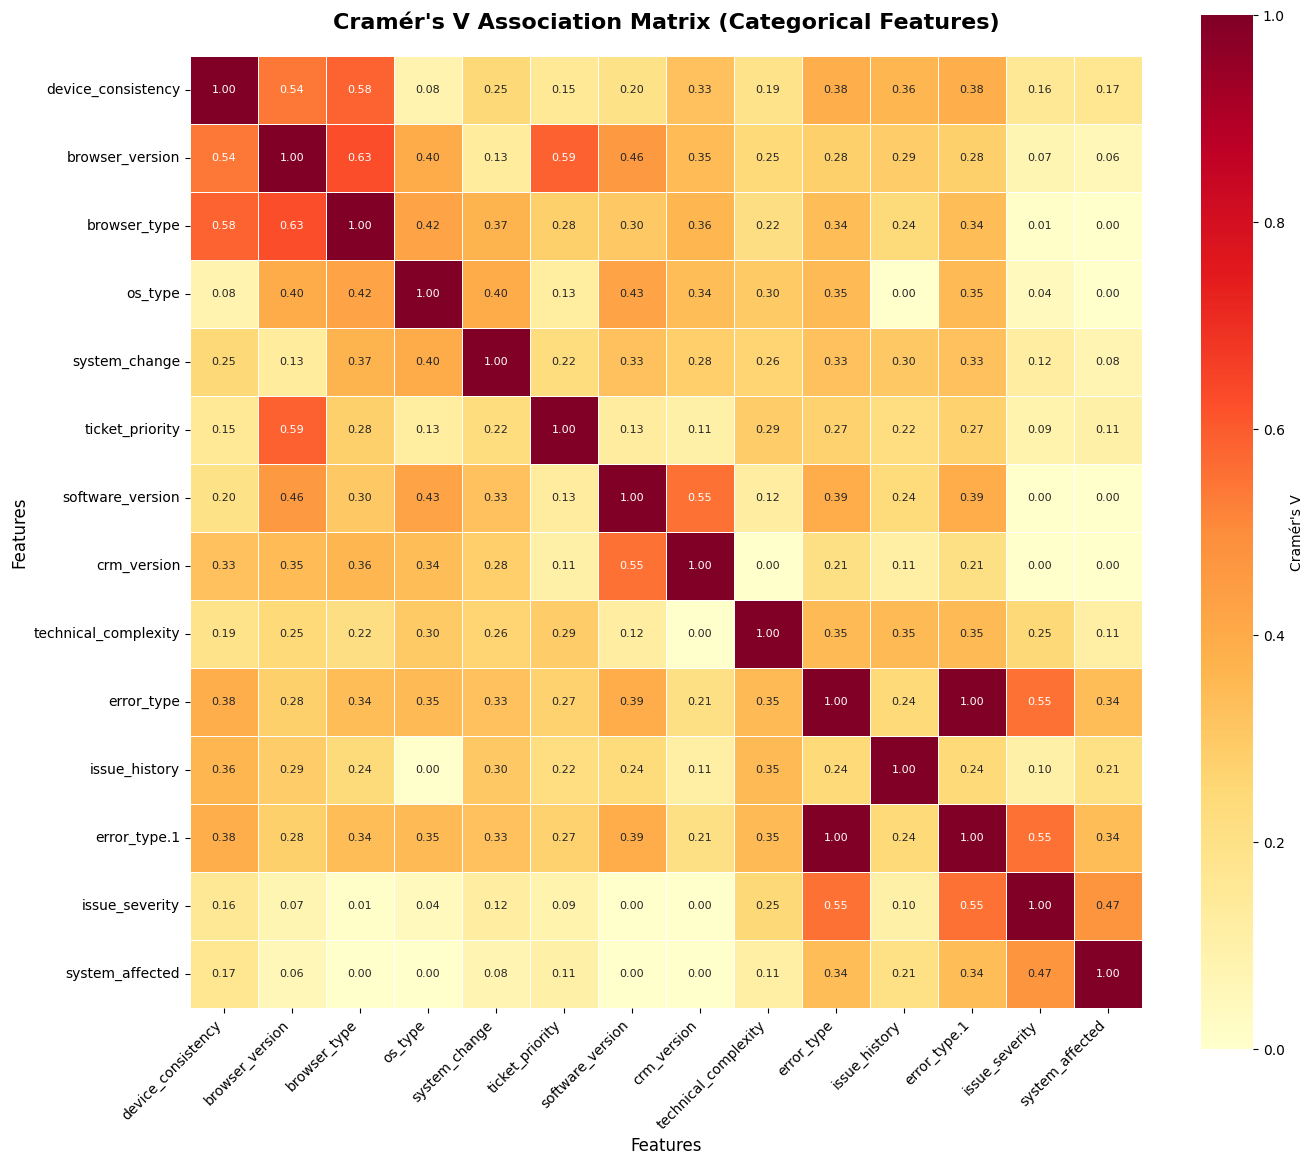


Highly Correlated Feature Pairs (Cramér's V > 0.7)
  error_type <-> error_type.1: 1.000


In [ ]:
# Visualize Cramér's V Association Matrix
plt.figure(figsize=(14, 12))

# Create mask for upper triangle (optional, for cleaner visualization)
mask = np.triu(np.ones_like(cramers_matrix, dtype=bool), k=1)

ax = sns.heatmap(
    cramers_matrix,
    mask=None,  # Show full matrix
    annot=True,
    fmt='.2f',
    cmap='YlOrRd',
    vmin=0,
    vmax=1,
    cbar_kws={'label': "Cramér's V"},
    square=True,
    linewidths=0.5,
    annot_kws={"size": 8}
)

plt.title("Cramér's V Association Matrix (Categorical Features)", fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.savefig('outputs/cramers_v_matrix.png', dpi=300, bbox_inches='tight')
print("✓ Visualization saved to outputs/cramers_v_matrix.png")
plt.show()

# Identify highly correlated feature pairs (excluding diagonal)
print("\n" + "="*60)
print("Highly Correlated Feature Pairs (Cramér's V > 0.7)")
print("="*60)
high_corr_pairs = []
for i in range(len(categorical_features)):
    for j in range(i+1, len(categorical_features)):
        col1 = categorical_features[i]
        col2 = categorical_features[j]
        v = cramers_matrix.loc[col1, col2]
        if v > 0.7 and not np.isnan(v):
            high_corr_pairs.append((col1, col2, v))

if high_corr_pairs:
    high_corr_pairs.sort(key=lambda x: x[2], reverse=True)
    for col1, col2, v in high_corr_pairs:
        print(f"  {col1} <-> {col2}: {v:.3f}")
else:
    print("  No highly correlated pairs found (threshold: 0.7)")

Calculating feature importance via Cramér's V with target variable...

Feature Importance Ranking (Cramér's V with ticket_created):
                      Cramers_V
system_change          0.259452
ticket_priority        0.218237
error_type.1           0.149557
error_type             0.149557
technical_complexity   0.144194
issue_history          0.125459
issue_severity         0.113052
device_consistency     0.088704
system_affected        0.055916
os_type                0.036488
browser_type           0.000000
browser_version        0.000000
software_version       0.000000
crm_version            0.000000

✓ Feature importance plot saved to outputs/feature_importance_cramers_v.png


<Figure size 1000x800 with 0 Axes>

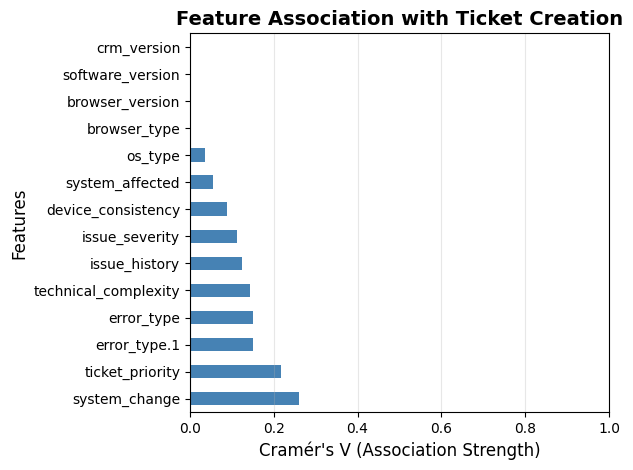

In [ ]:
# Calculate Cramér's V between each categorical feature and the target variable
print("Calculating feature importance via Cramér's V with target variable...")
print("="*60)

target_correlations = {}

for col in categorical_features:
    try:
        v = cramers_v(X_filled[col], y)
        target_correlations[col] = v
    except Exception as e:
        print(f"Warning: Could not calculate for {col}: {e}")
        target_correlations[col] = np.nan

# Create DataFrame and sort by correlation strength
correlation_df = pd.DataFrame.from_dict(
    target_correlations,
    orient='index',
    columns=['Cramers_V']
).sort_values(by='Cramers_V', ascending=False)

print("\nFeature Importance Ranking (Cramér's V with ticket_created):")
print("="*60)
print(correlation_df)

# Visualize feature importance
plt.figure(figsize=(10, 8))
ax = correlation_df.plot(kind='barh', legend=False, color='steelblue')
plt.xlabel("Cramér's V (Association Strength)", fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title("Feature Association with Ticket Creation", fontsize=14, fontweight='bold')
plt.xlim(0, 1)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('outputs/feature_importance_cramers_v.png', dpi=300, bbox_inches='tight')
print("\n✓ Feature importance plot saved to outputs/feature_importance_cramers_v.png")
plt.show()

Analyzing Missingness Patterns
             Feature  Missing_Count  Missing_Percentage        Type
           thread_id              0                 0.0   Numerical
        email_number              0                 0.0   Numerical
     rollback_status              0                 0.0   Numerical
  cache_clear_status              0                 0.0   Numerical
diagnostics_required              0                 0.0   Numerical
  device_consistency              0                 0.0 Categorical
     browser_version              0                 0.0 Categorical
        browser_type              0                 0.0 Categorical
  issue_reproduction              0                 0.0   Numerical
    support_required              0                 0.0   Numerical
             os_type              0                 0.0 Categorical
       system_change              0                 0.0 Categorical
     upgrade_related              0                 0.0   Numerical
     ticket_prior

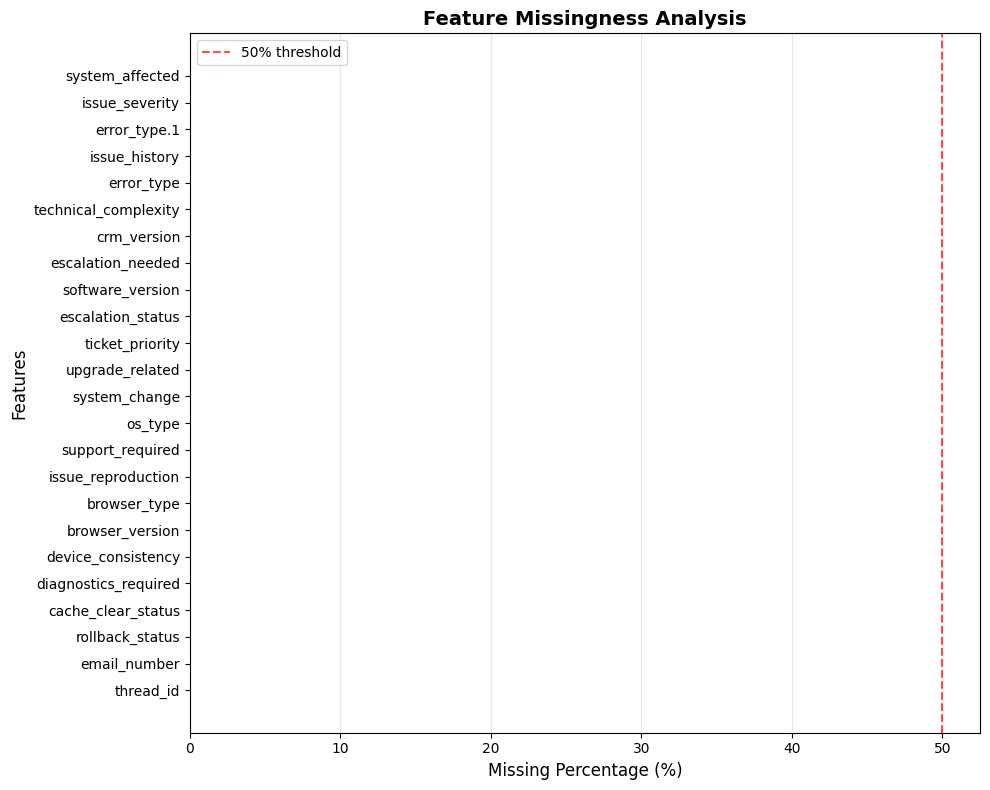

In [ ]:
# Analyze missingness patterns
print("Analyzing Missingness Patterns")
print("="*60)

missing_stats = []
for col in X.columns:
    missing_count = X[col].isna().sum()
    missing_pct = (missing_count / len(X)) * 100
    missing_stats.append({
        'Feature': col,
        'Missing_Count': missing_count,
        'Missing_Percentage': missing_pct,
        'Type': 'Categorical' if col in categorical_features else 'Numerical'
    })

missing_df = pd.DataFrame(missing_stats).sort_values('Missing_Percentage', ascending=False)
print(missing_df.to_string(index=False))

# Visualize missingness
plt.figure(figsize=(10, 8))
colors = ['coral' if x in categorical_features else 'skyblue' for x in missing_df['Feature']]
plt.barh(missing_df['Feature'], missing_df['Missing_Percentage'], color=colors)
plt.xlabel('Missing Percentage (%)', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Feature Missingness Analysis', fontsize=14, fontweight='bold')
plt.axvline(x=50, color='red', linestyle='--', label='50% threshold', alpha=0.7)
plt.legend()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('outputs/feature_missingness.png', dpi=300, bbox_inches='tight')
print("\n✓ Missingness plot saved to outputs/feature_missingness.png")
plt.show()

In [ ]:
#drop resolution_time and software_version.1 columns
df.drop(columns=["resolution_time", "software_version.1","error_type.1"], inplace=True)
#df.drop(columns=["error_type.1"], inplace=True)
#save
df.to_csv("outputs/stage4_final_dataset.csv", index=False)

## Stage 6: Binary Classification Models

According to Section 4.1 of the paper:
- Train gradient boosting decision trees (GBDT) and other classification models
- Use the structured dataset D from Stage 4 with selected features from Stage 5
- Predict whether a ticket should be created at each email point: h: R^q → {0, 1}
- Benchmark multiple models: CATBoost, XGBoost, LightGBM, Random Forest, EBM, and Naive Bayes
- Perform 5-fold stratified cross-validation
- Evaluate using ROC-AUC, Precision, Recall, and F1 scores with 95% confidence intervals

As described in the paper (Section 5.4), we implement 6 classification models with default hyperparameters and compare their performance on predicting ticket creation timing.

In [ ]:
# Install required machine learning packages
!pip install -U --quiet catboost xgboost lightgbm interpret scikit-learn imbalanced-learn


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# Import machine learning libraries
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, make_scorer
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from interpret.glassbox import ExplainableBoostingClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

print("✓ Machine learning libraries imported successfully")

✓ Machine learning libraries imported successfully


### 6.1 Load and Prepare Data

Load the cumulative dataset from Stage 4 and prepare features for model training.

In [ ]:
# Load the cumulative dataset from Stage 4
DATASET_PATH = "outputs/stage4_final_dataset.csv"

df = pd.read_csv(DATASET_PATH)

print(f"Dataset loaded: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nTarget distribution:")
print(df['ticket_created'].value_counts())
print(f"\nClass balance: {df['ticket_created'].value_counts(normalize=True)}")
print(f"\nFirst few rows:")
print(df.head())

Dataset loaded: (454, 24)

Columns: ['thread_id', 'email_number', 'rollback_status', 'cache_clear_status', 'diagnostics_required', 'device_consistency', 'browser_version', 'browser_type', 'issue_reproduction', 'support_required', 'os_type', 'system_change', 'upgrade_related', 'ticket_priority', 'escalation_status', 'software_version', 'escalation_needed', 'crm_version', 'technical_complexity', 'error_type', 'issue_history', 'issue_severity', 'system_affected', 'ticket_created']

Target distribution:
ticket_created
0    227
1    227
Name: count, dtype: int64

Class balance: ticket_created
0    0.5
1    0.5
Name: proportion, dtype: float64

First few rows:
   thread_id  email_number  rollback_status  cache_clear_status  \
0        268             3            False               False   
1         55             2            False                True   
2         39             3            False                True   
3         14             3            False               False   
4 

### 6.2 Data Preprocessing

Prepare the data for model training:
- Encode categorical features (label encoding for tree-based models)
- Standardize numerical features
- Handle missing values (use median/mode imputation)
- Create separate datasets for models that don't handle categorical features natively

In [ ]:
# Create a copy for preprocessing
X_processed = X.copy()

# Handle missing values
# For numerical features: fill with median
for col in numerical_features:
    if X_processed[col].isnull().any():
        median_val = X_processed[col].median()
        X_processed[col].fillna(median_val, inplace=True)
        print(f"Filled {col} missing values with median: {median_val}")

# For categorical features: fill with mode or 'Unknown'
for col in categorical_features:
    if X_processed[col].isnull().any():
        mode_val = X_processed[col].mode()
        if len(mode_val) > 0:
            X_processed[col].fillna(mode_val[0], inplace=True)
            print(f"Filled {col} missing values with mode: {mode_val[0]}")
        else:
            X_processed[col].fillna('Unknown', inplace=True)
            print(f"Filled {col} missing values with 'Unknown'")

print(f"\n✓ Missing values handled")
print(f"Remaining missing values: {X_processed.isnull().sum().sum()}")


✓ Missing values handled
Remaining missing values: 0


In [ ]:
# Prepare two versions of the dataset:
# 1. Label-encoded for tree-based models (CATBoost, XGBoost, LightGBM, Random Forest, EBM)
# 2. One-hot encoded and scaled for Naive Bayes

# Version 1: Label encoding for tree-based models
X_label_encoded = X_processed.copy()
label_encoders = {}

for col in categorical_features:
    le = LabelEncoder()
    X_label_encoded[col] = le.fit_transform(X_label_encoded[col].astype(str))
    label_encoders[col] = le

print("✓ Label encoding completed for tree-based models")
print(f"Shape: {X_label_encoded.shape}")

# Version 2: One-hot encoding and scaling for Naive Bayes
X_onehot = pd.get_dummies(X_processed, columns=categorical_features, drop_first=True)

# Scale numerical features
scaler = StandardScaler()
if len(numerical_features) > 0:
    X_onehot[numerical_features] = scaler.fit_transform(X_onehot[numerical_features])

print("✓ One-hot encoding and scaling completed for Naive Bayes")
print(f"Shape after one-hot encoding: {X_onehot.shape}")

✓ Label encoding completed for tree-based models
Shape: (454, 24)
✓ One-hot encoding and scaling completed for Naive Bayes
Shape after one-hot encoding: (454, 293)


### 6.3 Model Definition and Cross-Validation

1. **CATBoost**: Gradient boosting with native categorical feature handling
2. **XGBoost**: Extreme gradient boosting
3. **LightGBM**: Light gradient boosting machine
4. **Random Forest**: Ensemble of decision trees
5. **EBM (Explainable Boosting Machine)**: Interpretable gradient boosting
6. **Naive Bayes**: Baseline probabilistic classifier

Each model is evaluated using 5-fold stratified cross-validation with metrics: ROC-AUC, Precision, Recall, F1

In [ ]:
# Define models with default hyperparameters
models = {
    'CATBoost': (CatBoostClassifier(verbose=0, random_state=42), X_label_encoded),
    'XGBoost': (XGBClassifier(random_state=42, eval_metric='logloss'), X_label_encoded),
    'LightGBM': (LGBMClassifier(random_state=42, verbose=-1), X_label_encoded),
    'Random Forest': (RandomForestClassifier(random_state=42), X_label_encoded),
    'EBM': (ExplainableBoostingClassifier(random_state=42), X_label_encoded),
    'Naive Bayes': (GaussianNB(), X_onehot)
}

print("✓ Models defined:")
for model_name in models.keys():
    print(f"  - {model_name}")

✓ Models defined:
  - CATBoost
  - XGBoost
  - LightGBM
  - Random Forest
  - EBM
  - Naive Bayes


In [ ]:
# Function to compute 95% confidence intervals using Student's t-distribution
def compute_confidence_interval(scores, confidence=0.95):
    """
    Compute confidence interval for cross-validation scores.

    Args:
        scores: Array of scores from cross-validation
        confidence: Confidence level (default: 0.95 for 95% CI)

    Returns:
        mean, margin_of_error
    """
    n = len(scores)
    mean = np.mean(scores)
    std_err = stats.sem(scores)  # Standard error of the mean
    margin = std_err * stats.t.ppf((1 + confidence) / 2, n - 1)  # t-distribution
    return mean, margin

# Perform 5-fold stratified cross-validation for all models
n_folds = 5
cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

# Define scoring metrics
scoring = {
    'roc_auc': 'roc_auc',
    'precision': make_scorer(precision_score, zero_division=0),
    'recall': make_scorer(recall_score, zero_division=0),
    'f1': make_scorer(f1_score, zero_division=0)
}

results = {}

print("Starting 5-fold cross-validation for all models...")
print("=" * 70)

for model_name, (model, X_data) in models.items():
    print(f"\n{model_name}:")
    print("-" * 50)

    # Perform cross-validation
    cv_results = cross_validate(
        model, X_data, y,
        cv=cv,
        scoring=scoring,
        return_train_score=False,
        n_jobs=-1
    )

    # Compute mean and 95% CI for each metric
    metrics = {}
    for metric_name in ['roc_auc', 'precision', 'recall', 'f1']:
        scores = cv_results[f'test_{metric_name}']
        mean, margin = compute_confidence_interval(scores)
        metrics[metric_name] = {'mean': mean, 'margin': margin, 'scores': scores}
        print(f"  {metric_name.upper():12s}: {mean:.2f} ± {margin:.2f}")

    results[model_name] = metrics

print("\n" + "=" * 70)
print("✓ Cross-validation completed for all models")

Starting 5-fold cross-validation for all models...

CATBoost:
--------------------------------------------------
  ROC_AUC     : 0.79 ± 0.05
  PRECISION   : 0.70 ± 0.03
  RECALL      : 0.78 ± 0.06
  F1          : 0.73 ± 0.04

XGBoost:
--------------------------------------------------
  ROC_AUC     : 0.81 ± 0.03
  PRECISION   : 0.73 ± 0.08
  RECALL      : 0.73 ± 0.07
  F1          : 0.73 ± 0.07

LightGBM:
--------------------------------------------------
  ROC_AUC     : 0.80 ± 0.04
  PRECISION   : 0.71 ± 0.06
  RECALL      : 0.74 ± 0.06
  F1          : 0.72 ± 0.06

Random Forest:
--------------------------------------------------
  ROC_AUC     : 0.75 ± 0.08
  PRECISION   : 0.71 ± 0.05
  RECALL      : 0.76 ± 0.06
  F1          : 0.73 ± 0.04

EBM:
--------------------------------------------------
  ROC_AUC     : 0.78 ± 0.06
  PRECISION   : 0.68 ± 0.04
  RECALL      : 0.74 ± 0.03
  F1          : 0.71 ± 0.02

Naive Bayes:
--------------------------------------------------
  ROC_AUC     :

### 6.4 Results Summary

Create a comprehensive results table comparing all models.

In [ ]:
# Create results table
results_data = []

for model_name, metrics in results.items():
    row = {
        'Model': model_name,
        'ROC-AUC': f"{metrics['roc_auc']['mean']:.2f} ± {metrics['roc_auc']['margin']:.2f}",
        'Precision': f"{metrics['precision']['mean']:.2f} ± {metrics['precision']['margin']:.2f}",
        'Recall': f"{metrics['recall']['mean']:.2f} ± {metrics['recall']['margin']:.2f}",
        'F1': f"{metrics['f1']['mean']:.2f} ± {metrics['f1']['margin']:.2f}",
        'ROC-AUC_mean': metrics['roc_auc']['mean'],  # For sorting
    }
    results_data.append(row)

# Create DataFrame and sort by ROC-AUC (descending)
results_df = pd.DataFrame(results_data)
results_df = results_df.sort_values('ROC-AUC_mean', ascending=False)
results_df = results_df.drop(columns=['ROC-AUC_mean'])

# Display results table
print("\n" + "=" * 80)
print("MODEL PERFORMANCE COMPARISON (5-Fold Cross-Validation)")
print("=" * 80)
print(results_df.to_string(index=False))
print("=" * 80)

# Save results to CSV
results_save_path = "outputs/stage6_model_results.csv"
results_df.to_csv(results_save_path, index=False)
print(f"\n✓ Results saved to: {results_save_path}")


MODEL PERFORMANCE COMPARISON (5-Fold Cross-Validation)
        Model     ROC-AUC   Precision      Recall          F1
      XGBoost 0.81 ± 0.03 0.73 ± 0.08 0.73 ± 0.07 0.73 ± 0.07
     LightGBM 0.80 ± 0.04 0.71 ± 0.06 0.74 ± 0.06 0.72 ± 0.06
     CATBoost 0.79 ± 0.05 0.70 ± 0.03 0.78 ± 0.06 0.73 ± 0.04
          EBM 0.78 ± 0.06 0.68 ± 0.04 0.74 ± 0.03 0.71 ± 0.02
Random Forest 0.75 ± 0.08 0.71 ± 0.05 0.76 ± 0.06 0.73 ± 0.04
  Naive Bayes 0.52 ± 0.07 0.41 ± 0.11 0.14 ± 0.07 0.20 ± 0.09

✓ Results saved to: outputs/stage6_model_results.csv


### 6.5 Performance Visualization

Visualize model performance comparison using bar charts with error bars representing 95% confidence intervals.

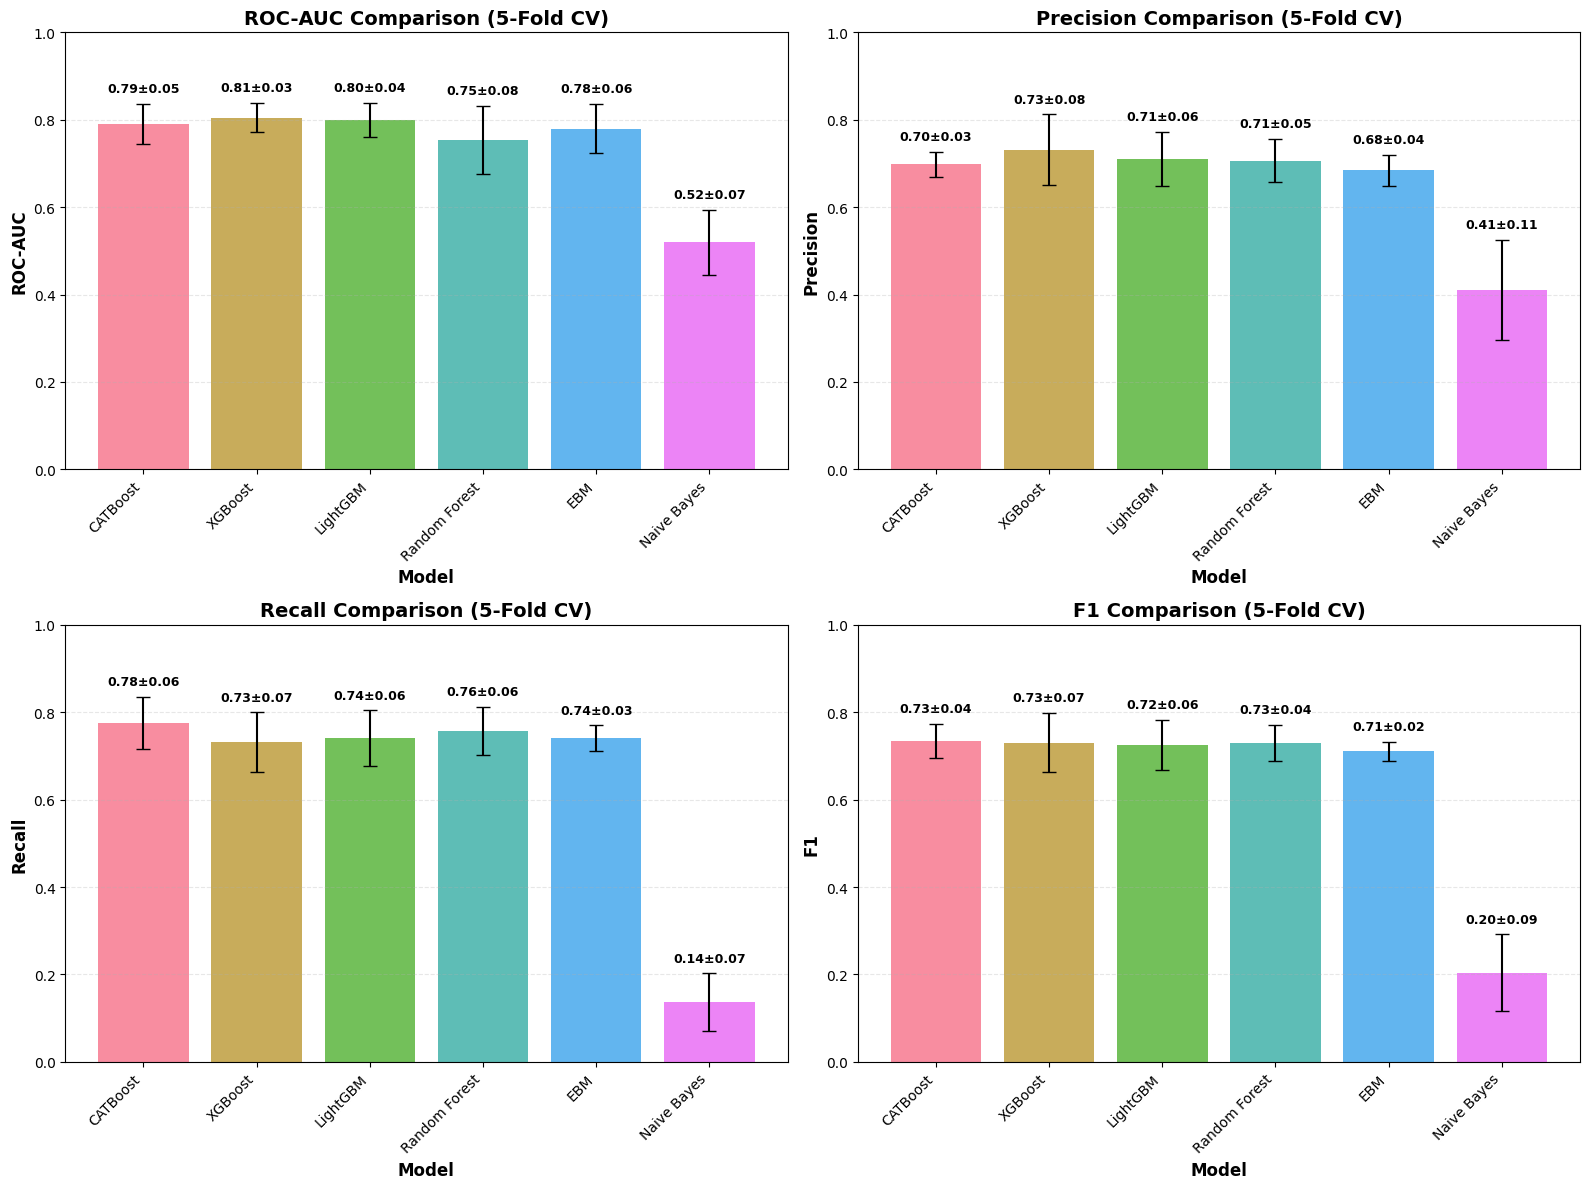

✓ Visualization saved to: outputs/stage6_model_comparison.png


In [ ]:
# Prepare data for visualization
model_names = list(results.keys())
metrics_to_plot = ['roc_auc', 'precision', 'recall', 'f1']
metric_labels = ['ROC-AUC', 'Precision', 'Recall', 'F1']

# Create subplots for each metric
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, (metric_key, metric_label) in enumerate(zip(metrics_to_plot, metric_labels)):
    ax = axes[idx]

    # Extract means and margins for this metric
    means = [results[model][metric_key]['mean'] for model in model_names]
    margins = [results[model][metric_key]['margin'] for model in model_names]

    # Create bar chart
    x_pos = np.arange(len(model_names))
    bars = ax.bar(x_pos, means, yerr=margins, capsize=5, alpha=0.8,
                   color=sns.color_palette("husl", len(model_names)))

    # Customize plot
    ax.set_xlabel('Model', fontsize=12, fontweight='bold')
    ax.set_ylabel(metric_label, fontsize=12, fontweight='bold')
    ax.set_title(f'{metric_label} Comparison (5-Fold CV)', fontsize=14, fontweight='bold')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(model_names, rotation=45, ha='right')
    ax.set_ylim([0, 1.0])
    ax.grid(axis='y', alpha=0.3, linestyle='--')

    # Add value labels on bars
    for i, (bar, mean, margin) in enumerate(zip(bars, means, margins)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + margin + 0.02,
                f'{mean:.2f}±{margin:.2f}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('outputs/stage6_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualization saved to: outputs/stage6_model_comparison.png")

### 6.6 Summary and Best Model Identification

Identify the best-performing model based on ROC-AUC score.

In [ ]:
# Identify best model
best_model_name = max(results.keys(), key=lambda x: results[x]['roc_auc']['mean'])
best_metrics = results[best_model_name]

print("\n" + "=" * 80)
print("STAGE 6 SUMMARY: BINARY CLASSIFICATION MODELS")
print("=" * 80)
print(f"\n✓ Evaluated 6 classification models using 5-fold stratified cross-validation")
print(f"✓ Dataset: {X.shape[0]} instances, {X.shape[1]} features")
print(f"✓ Class distribution: {(y==0).sum()} negative, {(y==1).sum()} positive")
print(f"\n🏆 BEST MODEL: {best_model_name}")
print("-" * 80)
print(f"  ROC-AUC:   {best_metrics['roc_auc']['mean']:.2f} ± {best_metrics['roc_auc']['margin']:.2f}")
print(f"  Precision: {best_metrics['precision']['mean']:.2f} ± {best_metrics['precision']['margin']:.2f}")
print(f"  Recall:    {best_metrics['recall']['mean']:.2f} ± {best_metrics['recall']['margin']:.2f}")
print(f"  F1 Score:  {best_metrics['f1']['mean']:.2f} ± {best_metrics['f1']['margin']:.2f}")

print("\n" + "=" * 80)
print("KEY FINDINGS:")
print("-" * 80)

# Sort models by ROC-AUC
sorted_models = sorted(results.items(), key=lambda x: x[1]['roc_auc']['mean'], reverse=True)

print(f"\nModel Ranking (by ROC-AUC):")
for rank, (model_name, metrics) in enumerate(sorted_models, 1):
    auc_mean = metrics['roc_auc']['mean']
    auc_margin = metrics['roc_auc']['margin']
    print(f"  {rank}. {model_name:20s} - ROC-AUC: {auc_mean:.2f} ± {auc_margin:.2f}")

print("\n" + "=" * 80)
print("✓ Stage 6 Complete!")
print("=" * 80)


STAGE 6 SUMMARY: BINARY CLASSIFICATION MODELS

✓ Evaluated 6 classification models using 5-fold stratified cross-validation
✓ Dataset: 454 instances, 24 features
✓ Class distribution: 227 negative, 227 positive

🏆 BEST MODEL: XGBoost
--------------------------------------------------------------------------------
  ROC-AUC:   0.81 ± 0.03
  Precision: 0.73 ± 0.08
  Recall:    0.73 ± 0.07
  F1 Score:  0.73 ± 0.07

KEY FINDINGS:
--------------------------------------------------------------------------------

Model Ranking (by ROC-AUC):
  1. XGBoost              - ROC-AUC: 0.81 ± 0.03
  2. LightGBM             - ROC-AUC: 0.80 ± 0.04
  3. CATBoost             - ROC-AUC: 0.79 ± 0.05
  4. EBM                  - ROC-AUC: 0.78 ± 0.06
  5. Random Forest        - ROC-AUC: 0.75 ± 0.08
  6. Naive Bayes          - ROC-AUC: 0.52 ± 0.07

✓ Stage 6 Complete!


## Stage 7: Active Feature Learning with SHAP

According to Sections 4.2 and 4.3 of the paper, we:
- Use SHAP (SHapley Additive exPlanations) for local interpretability
- Implement Phase 1: Missing Feature Impact Assessment
- Implement Phase 2: Prediction Stability Check
- Make informed decisions about when to request additional information vs immediate predictions

The algorithm operates in three phases:
1. **Phase 1: Missing Feature Impact Assessment** - Compute SHAP values and identify missing features, calculate cumulative importance
2. **Phase 2: Prediction Stability Check** - Simulate imputation with plausible values and check prediction variance
3. **Phase 3: Confident Prediction** - If both criteria pass, return the prediction with high confidence

In [ ]:
# Install SHAP for explainability
!pip install shap

In [ ]:
import shap
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, make_scorer
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

print(f"✓ SHAP version: {shap.__version__}")
print(f"✓ Ready for Active Feature Learning implementation")

✓ SHAP version: 0.50.0
✓ Ready for Active Feature Learning implementation


In [ ]:
# Load the final dataset from Stage 4
df_final = pd.read_csv("outputs/stage4_final_dataset.csv")

print(f"Loaded dataset with {df_final.shape[0]} instances and {df_final.shape[1]} columns")
print(f"\nTarget variable distribution:")
print(df_final['ticket_created'].value_counts())
print(f"\nSample of dataset:")
print(df_final.head(3))

Loaded dataset with 454 instances and 24 columns

Target variable distribution:
ticket_created
0    227
1    227
Name: count, dtype: int64

Sample of dataset:
   thread_id  email_number  rollback_status  cache_clear_status  \
0        268             3            False               False   
1         55             2            False                True   
2         39             3            False                True   

   diagnostics_required                         device_consistency  \
0                 False  consistent across both Chrome and Firefox   
1                  True  consistent across both Chrome and Firefox   
2                  True  consistent across both Chrome and Firefox   

  browser_version browser_type  issue_reproduction  support_required  ...  \
0         unknown      unknown               False              True  ...   
1      Chrome 129       Chrome               False              True  ...   
2      Chrome 120       Chrome                True          

In [ ]:
# Prepare data for training
# Separate features and target
X = df_final.drop(['thread_id', 'email_number', 'ticket_created'], axis=1, errors='ignore')
y = df_final['ticket_created']

# Identify categorical features for CatBoost
categorical_features = []
for col in X.columns:
    if X[col].dtype == 'object' or X[col].nunique() < 10:
        categorical_features.append(col)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


print(f"Features: {X.shape[1]}")
print(f"Categorical features: {len(categorical_features)}")
print(f"Categorical feature names: {categorical_features[:10]}...")  # Show first 10
print(f"\nTarget distribution:")
print(y.value_counts())
print(f"Positive class percentage: {y.mean()*100:.2f}%")

Features: 21
Categorical features: 21
Categorical feature names: ['rollback_status', 'cache_clear_status', 'diagnostics_required', 'device_consistency', 'browser_version', 'browser_type', 'issue_reproduction', 'support_required', 'os_type', 'system_change']...

Target distribution:
ticket_created
0    227
1    227
Name: count, dtype: int64
Positive class percentage: 50.00%


In [ ]:
# Train CATBoost model
print("Training CATBoost model...")

# Create CatBoost classifier with default hyperparameters
catboost_model = CatBoostClassifier(
    random_seed=42,
    verbose=100,
    cat_features=categorical_features
)

# Train the model
catboost_model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    verbose=100
)

# Evaluate on test set
y_pred = catboost_model.predict(X_test)
y_pred_proba = catboost_model.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test, y_pred_proba)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\n" + "="*80)
print("MODEL EVALUATION ON TEST SET")
print("="*80)
print(f"ROC-AUC:   {roc_auc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print("="*80)

Training CATBoost model...
Learning rate set to 0.024672
0:	learn: 0.6883102	test: 0.6894314	best: 0.6894314 (0)	total: 30ms	remaining: 29.9s
100:	learn: 0.4905769	test: 0.5955078	best: 0.5955078 (100)	total: 3.96s	remaining: 35.2s
200:	learn: 0.3879054	test: 0.5923801	best: 0.5849690 (136)	total: 7.69s	remaining: 30.6s
300:	learn: 0.3011035	test: 0.5866991	best: 0.5849690 (136)	total: 11.2s	remaining: 26.1s
400:	learn: 0.2401922	test: 0.5759998	best: 0.5759998 (400)	total: 15s	remaining: 22.4s
500:	learn: 0.1929524	test: 0.5782470	best: 0.5749017 (411)	total: 18.7s	remaining: 18.7s
600:	learn: 0.1600798	test: 0.5780656	best: 0.5749017 (411)	total: 22.6s	remaining: 15s
700:	learn: 0.1346425	test: 0.5833716	best: 0.5749017 (411)	total: 26.4s	remaining: 11.3s
800:	learn: 0.1149781	test: 0.5847761	best: 0.5749017 (411)	total: 30s	remaining: 7.45s
900:	learn: 0.0996466	test: 0.5903478	best: 0.5749017 (411)	total: 33.5s	remaining: 3.68s
999:	learn: 0.0869301	test: 0.5942701	best: 0.5749017 

In [ ]:
# Initialize SHAP explainer with TreeSHAP
print("Initializing SHAP explainer...")
explainer = shap.TreeExplainer(catboost_model)

# Compute SHAP values for test set
print("Computing SHAP values for test set...")
shap_values = explainer(X_test)

print(f"✓ SHAP values computed")
print(f"  Shape: {shap_values.values.shape}")
print(f"  Base value: {shap_values.base_values[0]:.4f}")

Initializing SHAP explainer...
Computing SHAP values for test set...
✓ SHAP values computed
  Shape: (91, 21)
  Base value: -0.1508


In [ ]:
def identify_missing_features(x_instance: pd.Series) -> list:
    """
    Identify missing features in an instance.

    Args:
        x_instance: Feature vector as pandas Series

    Returns:
        List of feature indices with missing values
    """
    missing_indices = []
    for idx, (feature_name, value) in enumerate(x_instance.items()):
        # Check for missing values (NaN, None, "unknown", empty string)
        if pd.isna(value) or value == "unknown" or value == "":
            missing_indices.append(idx)

    return missing_indices


def compute_missing_impact(shap_values_instance: np.ndarray, missing_indices: list) -> float:
    """
    Compute cumulative importance of missing features.

    Phase 1: Missing Feature Impact Assessment
    MissingImpact(x) = Σ |φ_j(x)| for j ∈ M(x)

    Args:
        shap_values_instance: SHAP values for the instance
        missing_indices: Indices of missing features

    Returns:
        Cumulative absolute SHAP values of missing features
    """
    if len(missing_indices) == 0:
        return 0.0

    missing_impact = np.sum(np.abs(shap_values_instance[missing_indices]))
    return missing_impact


def get_most_important_missing_feature(
    shap_values_instance: np.ndarray,
    missing_indices: list,
    feature_names: list
) -> tuple:
    """
    Identify the most important missing feature.

    j* = argmax_j∈M(x) |φ_j(x)|

    Args:
        shap_values_instance: SHAP values for the instance
        missing_indices: Indices of missing features
        feature_names: List of feature names

    Returns:
        Tuple of (feature_index, feature_name, shap_value)
    """
    if len(missing_indices) == 0:
        return None, None, 0.0

    # Get absolute SHAP values for missing features
    missing_shap_abs = np.abs(shap_values_instance[missing_indices])

    # Find the feature with maximum absolute SHAP value
    max_idx_in_missing = np.argmax(missing_shap_abs)
    max_feature_idx = missing_indices[max_idx_in_missing]
    max_feature_name = feature_names[max_feature_idx]
    max_shap_value = shap_values_instance[max_feature_idx]

    return max_feature_idx, max_feature_name, max_shap_value

print("✓ Phase 1 functions defined: Missing Feature Impact Assessment")

✓ Phase 1 functions defined: Missing Feature Impact Assessment


In [ ]:
def simulate_imputation_stability(
    x_instance: pd.Series,
    missing_indices: list,
    model: CatBoostClassifier,
    X_train: pd.DataFrame,
    n_samples: int = 1000,
) -> float:
    """
    Simulate imputation and check prediction stability.

    Phase 2: Prediction Stability Check
    For each missing feature, sample values from training distribution
    and compute prediction variance.

    Args:
        x_instance: Feature vector as pandas Series
        missing_indices: Indices of missing features
        model: Trained CatBoost model
        X_train: Training data for sampling values
        n_samples: Number of samples to draw per missing feature

    Returns:
        Variance of predictions across imputations
    """
    if len(missing_indices) == 0:
        return 0.0

    predictions = []
    feature_names = x_instance.index.tolist()

    # For each missing feature, sample plausible values
    for missing_idx in missing_indices:
        feature_name = feature_names[missing_idx]

        # Sample values from training distribution
        train_values = X_train[feature_name].dropna()

        # If no valid training values, skip this feature
        if len(train_values) == 0:
            continue

        # Sample n_samples values
        sampled_values = train_values.sample(n=min(n_samples, len(train_values)), replace=True)

        # Create imputed instances and get predictions
        for sampled_value in sampled_values:
            x_imputed = x_instance.copy()
            x_imputed.iloc[missing_idx] = sampled_value

            # Predict with imputed instance
            pred_proba = model.predict_proba(x_imputed.to_frame().T)[0, 1]
            predictions.append(pred_proba)

    # Calculate variance of predictions
    if len(predictions) > 1:
        variance = np.var(predictions)
    else:
        variance = 0.0

    return variance


def check_prediction_stability(
    variance: float,
    threshold_stab: float = 0.01
) -> bool:
    """
    Check if prediction is stable given variance threshold.

    Args:
        variance: Variance of predictions across imputations
        threshold_stab: Stability threshold (θ_stab)

    Returns:
        True if stable (variance <= threshold), False otherwise
    """
    return variance <= threshold_stab

print("✓ Phase 2 functions defined: Prediction Stability Check")

✓ Phase 2 functions defined: Prediction Stability Check


In [ ]:
def active_feature_learning_algorithm(
    x_instance: pd.Series,
    model: CatBoostClassifier,
    explainer: shap.TreeExplainer,
    X_train: pd.DataFrame,
    threshold_miss: float = 0.1,
    threshold_stab: float = 0.01,
    n_samples: int = 1000,
    verbose: bool = True
) -> dict:
    """
    Algorithm 1: Active Feature Learning for Prediction Refinement

    Input: Instance x, model h, thresholds θ_miss, θ_stab
    Output: Prediction decision and optional feature query

    Args:
        x_instance: Feature vector as pandas Series
        model: Trained classification model
        explainer: SHAP explainer
        X_train: Training data for sampling
        threshold_miss: Missing impact threshold (θ_miss)
        threshold_stab: Stability threshold (θ_stab)
        n_samples: Number of samples for stability check
        verbose: Whether to print detailed information

    Returns:
        Dictionary with decision, prediction, and details
    """
    feature_names = x_instance.index.tolist()

    # Step 1: Compute SHAP values using TreeSHAP
    shap_values_instance = explainer.shap_values(x_instance.to_frame().T)[0]

    # Step 2: Identify missing features M(x) = {j : x_j = ⊥}
    missing_indices = identify_missing_features(x_instance)

    if verbose:
        print(f"\n{'='*80}")
        print("ACTIVE FEATURE LEARNING ALGORITHM")
        print(f"{'='*80}")
        print(f"Total features: {len(feature_names)}")
        print(f"Missing features: {len(missing_indices)}")
        if len(missing_indices) > 0:
            print(f"Missing feature names: {[feature_names[i] for i in missing_indices]}")

    # Step 3: Compute MissingImpact(x) = Σ |φ_j(x)| for j ∈ M(x)
    missing_impact = compute_missing_impact(shap_values_instance, missing_indices)

    if verbose:
        print(f"\nPhase 1: Missing Feature Impact Assessment")
        print(f"  Missing Impact: {missing_impact:.4f}")
        print(f"  Threshold (θ_miss): {threshold_miss:.4f}")

    # Step 4: Phase 1 - Check if MissingImpact(x) > θ_miss
    if missing_impact > threshold_miss:
        # Select j* = argmax_j∈M(x) |φ_j(x)|
        max_idx, max_name, max_shap = get_most_important_missing_feature(
            shap_values_instance, missing_indices, feature_names
        )

        if verbose:
            print(f"  ❌ Missing impact exceeds threshold!")
            print(f"  Most important missing feature: {max_name}")
            print(f"  SHAP value: {max_shap:.4f}")
            print(f"\n  Decision: WITHHOLD prediction, request feature '{max_name}'")

        return {
            'decision': 'WITHHOLD',
            'reason': 'missing_impact',
            'feature_to_query': max_name,
            'feature_shap_value': max_shap,
            'missing_impact': missing_impact,
            'prediction': None,
            'prediction_proba': None
        }

    if verbose:
        print(f"  ✓ Missing impact is acceptable")

    # Step 5: Phase 2 - Prediction Stability Check
    if verbose:
        print(f"\nPhase 2: Prediction Stability Check")

    variance = simulate_imputation_stability(
        x_instance, missing_indices, model, X_train, n_samples
    )

    if verbose:
        print(f"  Prediction variance: {variance:.6f}")
        print(f"  Threshold (θ_stab): {threshold_stab:.6f}")

    # Step 6: Check if σ² > θ_stab
    if variance > threshold_stab:
        # Select j* = argmax_j∈M(x) |φ_j(x)|
        max_idx, max_name, max_shap = get_most_important_missing_feature(
            shap_values_instance, missing_indices, feature_names
        )

        if verbose:
            print(f"  ❌ Prediction is unstable!")
            print(f"  Most important missing feature: {max_name}")
            print(f"  SHAP value: {max_shap:.4f}")
            print(f"\n  Decision: WITHHOLD prediction, request feature '{max_name}'")

        return {
            'decision': 'WITHHOLD',
            'reason': 'unstable_prediction',
            'feature_to_query': max_name,
            'feature_shap_value': max_shap,
            'variance': variance,
            'prediction': None,
            'prediction_proba': None
        }

    if verbose:
        print(f"  ✓ Prediction is stable")

    # Step 7: Phase 3 - Confident Prediction
    # Both criteria satisfied, return prediction
    prediction = model.predict(x_instance.to_frame().T)[0]
    prediction_proba = model.predict_proba(x_instance.to_frame().T)[0, 1]

    if verbose:
        print(f"\nPhase 3: Confident Prediction")
        print(f"  ✓ Both criteria satisfied")
        print(f"  Prediction: {prediction} (probability: {prediction_proba:.4f})")
        print(f"\n  Decision: PREDICT with high confidence")

    return {
        'decision': 'PREDICT',
        'reason': 'confident',
        'feature_to_query': None,
        'missing_impact': missing_impact,
        'variance': variance,
        'prediction': prediction,
        'prediction_proba': prediction_proba
    }

print("✓ Algorithm 1 implemented: Active Feature Learning for Prediction Refinement")

✓ Algorithm 1 implemented: Active Feature Learning for Prediction Refinement


In [ ]:
# Test the algorithm on a few examples from the test set
print("="*80)
print("TESTING ACTIVE FEATURE LEARNING ALGORITHM")
print("="*80)

# Test on 3 random instances
test_indices = np.random.choice(X_test.index, size=3, replace=False)

for i, idx in enumerate(test_indices, 1):
    print(f"\n{'#'*80}")
    print(f"TEST INSTANCE {i} (Index: {idx})")
    print(f"{'#'*80}")

    x_instance = X_test.loc[idx]
    y_true = y_test.loc[idx]

    print(f"True label: {y_true}")

    # Run the algorithm
    result = active_feature_learning_algorithm(
        x_instance=x_instance,
        model=catboost_model,
        explainer=explainer,
        X_train=X_train,
        threshold_miss=0.2,
        threshold_stab=0.01,
        n_samples=1000,
        verbose=True
    )

    print(f"\n{'='*80}")
    print(f"RESULT SUMMARY")
    print(f"{'='*80}")
    print(f"Decision: {result['decision']}")
    if result['decision'] == 'WITHHOLD':
        print(f"Reason: {result['reason']}")
        print(f"Feature to query: {result['feature_to_query']}")
        print(f"Feature SHAP value: {result['feature_shap_value']:.4f}")
    else:
        print(f"Prediction: {result['prediction']}")
        print(f"Prediction probability: {result['prediction_proba']:.4f}")
        print(f"True label: {y_true}")
        print(f"Correct: {result['prediction'] == y_true}")
    print(f"{'='*80}")

TESTING ACTIVE FEATURE LEARNING ALGORITHM

################################################################################
TEST INSTANCE 1 (Index: 72)
################################################################################
True label: 1

ACTIVE FEATURE LEARNING ALGORITHM
Total features: 21
Missing features: 3
Missing feature names: ['browser_version', 'browser_type', 'crm_version']

Phase 1: Missing Feature Impact Assessment
  Missing Impact: 0.1215
  Threshold (θ_miss): 0.2000
  ✓ Missing impact is acceptable

Phase 2: Prediction Stability Check
  Prediction variance: 0.000274
  Threshold (θ_stab): 0.010000
  ✓ Prediction is stable

Phase 3: Confident Prediction
  ✓ Both criteria satisfied
  Prediction: 1 (probability: 0.8131)

  Decision: PREDICT with high confidence

RESULT SUMMARY
Decision: PREDICT
Prediction: 1
Prediction probability: 0.8131
True label: 1
Correct: True

################################################################################
TEST INSTANCE 2 (Inde

In [ ]:
# Evaluate algorithm performance on the entire test set
print("\n" + "="*80)
print("EVALUATING ALGORITHM ON ENTIRE TEST SET")
print("="*80)

# Run algorithm on all test instances
results = []
for idx in X_test.index:
    x_instance = X_test.loc[idx]
    y_true = y_test.loc[idx]

    result = active_feature_learning_algorithm(
        x_instance=x_instance,
        model=catboost_model,
        explainer=explainer,
        X_train=X_train,
        threshold_miss=0.2,
        threshold_stab=0.01,
        n_samples=1000,
        verbose=False
    )

    result['true_label'] = y_true
    result['instance_idx'] = idx
    results.append(result)

# Convert to DataFrame for analysis
results_df = pd.DataFrame(results)

# Calculate metrics
total_instances = len(results_df)
predict_count = (results_df['decision'] == 'PREDICT').sum()
withhold_count = (results_df['decision'] == 'WITHHOLD').sum()
coverage = predict_count / total_instances

# For predicted instances, calculate accuracy metrics
predicted_instances = results_df[results_df['decision'] == 'PREDICT']
if len(predicted_instances) > 0:
    y_pred_filtered = predicted_instances['prediction'].values
    y_true_filtered = predicted_instances['true_label'].values
    y_pred_proba_filtered = predicted_instances['prediction_proba'].values

    filtered_roc_auc = roc_auc_score(y_true_filtered, y_pred_proba_filtered)
    filtered_precision = precision_score(y_true_filtered, y_pred_filtered)
    filtered_recall = recall_score(y_true_filtered, y_pred_filtered)
    filtered_f1 = f1_score(y_true_filtered, y_pred_filtered)
else:
    filtered_roc_auc = filtered_precision = filtered_recall = filtered_f1 = 0.0

# Baseline metrics (all predictions)
baseline_roc_auc = roc_auc
baseline_precision = precision
baseline_recall = recall
baseline_f1 = f1

print(f"\n{'='*80}")
print("PERFORMANCE COMPARISON")
print(f"{'='*80}")
print(f"\nTotal test instances: {total_instances}")
print(f"Predicted instances: {predict_count} ({coverage*100:.1f}% coverage)")
print(f"Withheld instances: {withhold_count} ({(1-coverage)*100:.1f}%)")

print(f"\n{'='*80}")
print("BASELINE (All predictions)")
print(f"{'='*80}")
print(f"ROC-AUC:   {baseline_roc_auc:.4f}")
print(f"Precision: {baseline_precision:.4f}")
print(f"Recall:    {baseline_recall:.4f}")
print(f"F1 Score:  {baseline_f1:.4f}")
print(f"Coverage:  100%")

print(f"\n{'='*80}")
print("WITH ACTIVE FEATURE LEARNING")
print(f"{'='*80}")
print(f"ROC-AUC:   {filtered_roc_auc:.4f}  ({(filtered_roc_auc - baseline_roc_auc)/baseline_roc_auc*100:+.1f}%)")
print(f"Precision: {filtered_precision:.4f}  ({(filtered_precision - baseline_precision)/baseline_precision*100:+.1f}%)")
print(f"Recall:    {filtered_recall:.4f}  ({(filtered_recall - baseline_recall)/baseline_recall*100:+.1f}%)")
print(f"F1 Score:  {filtered_f1:.4f}  ({(filtered_f1 - baseline_f1)/baseline_f1*100:+.1f}%)")
print(f"Coverage:  {coverage*100:.1f}%")

print(f"\n{'='*80}")
print("WITHHELD INSTANCES ANALYSIS")
print(f"{'='*80}")
withheld_instances = results_df[results_df['decision'] == 'WITHHOLD']
if len(withheld_instances) > 0:
    withhold_reasons = withheld_instances['reason'].value_counts()
    print("Reasons for withholding:")
    for reason, count in withhold_reasons.items():
        print(f"  {reason}: {count} ({count/len(withheld_instances)*100:.1f}%)")

    print(f"\nTop features to query:")
    feature_query_counts = withheld_instances['feature_to_query'].value_counts().head(10)
    for feature, count in feature_query_counts.items():
        print(f"  {feature}: {count} times")
else:
    print("No instances were withheld")

print(f"\n{'='*80}")


EVALUATING ALGORITHM ON ENTIRE TEST SET

PERFORMANCE COMPARISON

Total test instances: 91
Predicted instances: 52 (57.1% coverage)
Withheld instances: 39 (42.9%)

BASELINE (All predictions)
ROC-AUC:   0.8008
Precision: 0.8333
Recall:    0.6731
F1 Score:  0.7447
Coverage:  100%

WITH ACTIVE FEATURE LEARNING
ROC-AUC:   0.7135  (-10.9%)
Precision: 0.8387  (+0.6%)
Recall:    0.7222  (+7.3%)
F1 Score:  0.7761  (+4.2%)
Coverage:  57.1%

WITHHELD INSTANCES ANALYSIS
Reasons for withholding:
  missing_impact: 39 (100.0%)

Top features to query:
  system_change: 12 times
  ticket_priority: 11 times
  browser_version: 7 times
  issue_history: 4 times
  crm_version: 2 times
  browser_type: 1 times
  technical_complexity: 1 times
  os_type: 1 times



SHAP VALUE VISUALIZATION

Instance index: 301
True label: 1
Prediction: 1
Prediction probability: 0.5699

Generating SHAP waterfall plot...


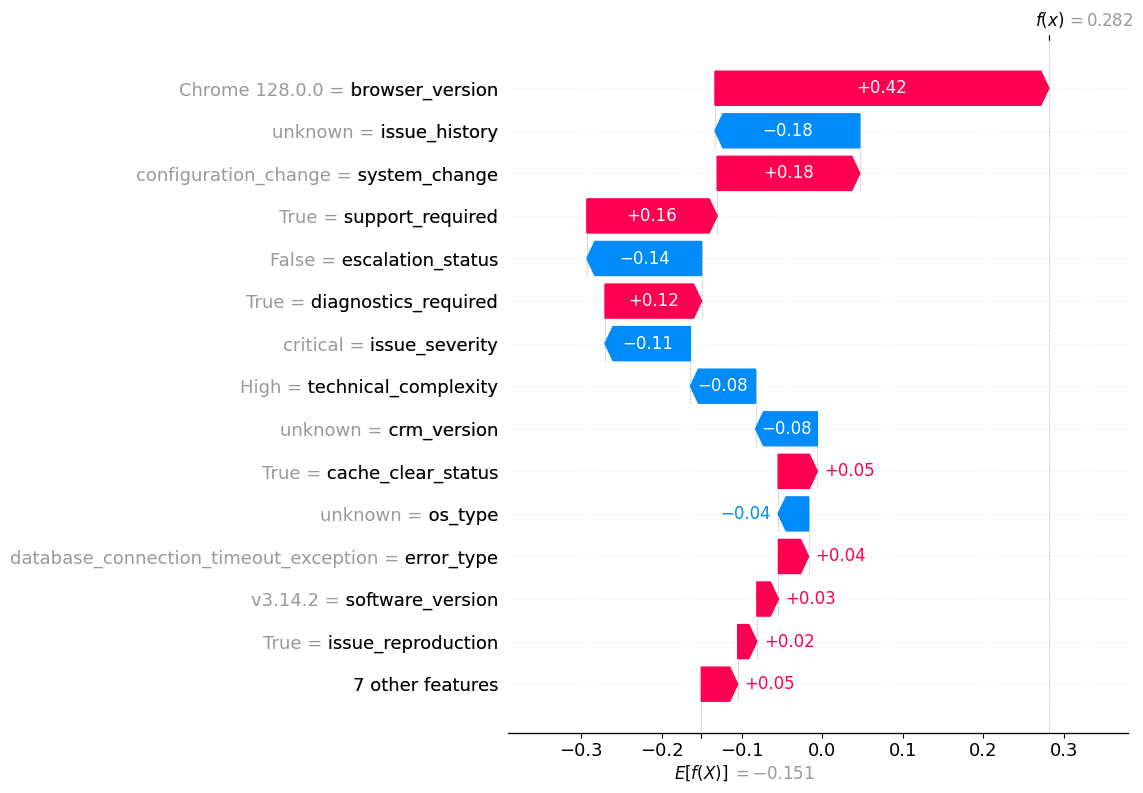

In [ ]:
# Visualize SHAP values for a sample instance
print("="*80)
print("SHAP VALUE VISUALIZATION")
print("="*80)

# Select an instance for visualization
sample_idx = X_test.index[0]
x_sample = X_test.loc[sample_idx]

print(f"\nInstance index: {sample_idx}")
print(f"True label: {y_test.loc[sample_idx]}")
print(f"Prediction: {catboost_model.predict(x_sample.to_frame().T)[0]}")
print(f"Prediction probability: {catboost_model.predict_proba(x_sample.to_frame().T)[0, 1]:.4f}")

# Compute SHAP values for this instance
shap_values_sample = explainer.shap_values(x_sample.to_frame().T)

# Create waterfall plot
print("\nGenerating SHAP waterfall plot...")
shap.plots.waterfall(shap.Explanation(
    values=shap_values_sample[0],
    base_values=explainer.expected_value,
    data=x_sample.values,
    feature_names=x_sample.index.tolist()
), max_display=15)


Generating SHAP summary plot for top features...


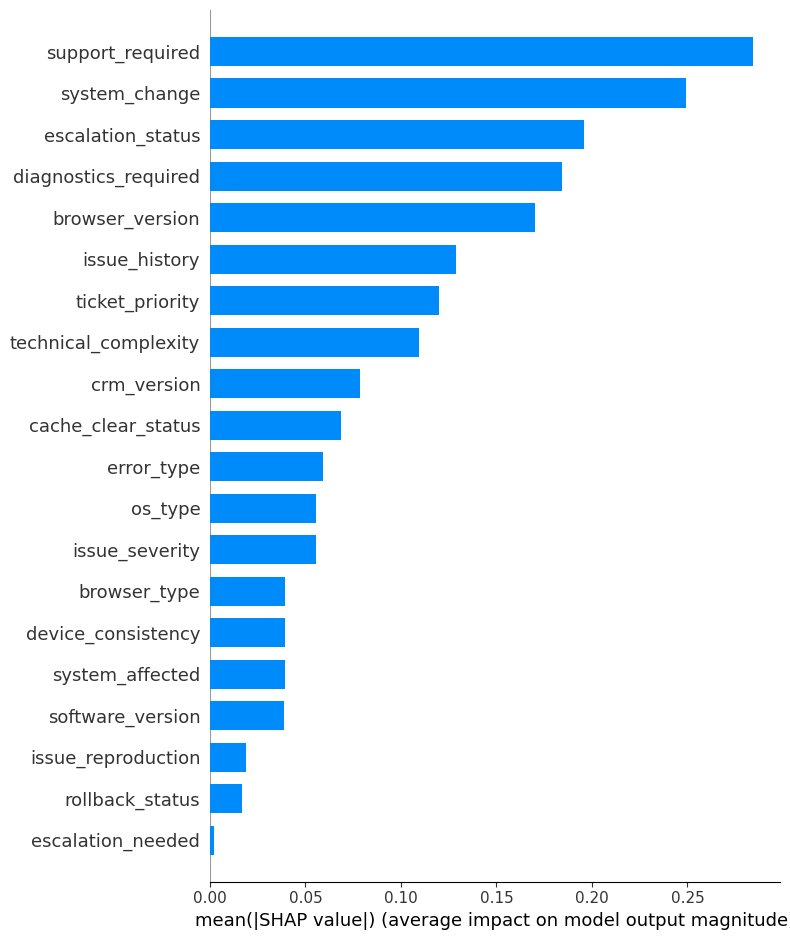

In [ ]:
# Create summary plot for top features
print("\nGenerating SHAP summary plot for top features...")

# Get SHAP values for all test instances
shap_values_all = explainer.shap_values(X_test)

# Create summary plot
shap.summary_plot(
    shap_values_all,
    X_test,
    max_display=20,
    plot_type="bar"
)

In [ ]:
# Save results to file
results_df.to_csv("outputs/stage7_active_learning_results.csv", index=False)
print("✓ Saved detailed results to outputs/stage7_active_learning_results.csv")

# Save summary metrics
summary_metrics = {
    "baseline": {
        "roc_auc": baseline_roc_auc,
        "precision": baseline_precision,
        "recall": baseline_recall,
        "f1": baseline_f1,
        "coverage": 1.0
    },
    "with_active_learning": {
        "roc_auc": filtered_roc_auc,
        "precision": filtered_precision,
        "recall": filtered_recall,
        "f1": filtered_f1,
        "coverage": coverage
    },
    "improvements": {
        "roc_auc_improvement": filtered_roc_auc - baseline_roc_auc,
        "precision_improvement": filtered_precision - baseline_precision,
        "recall_change": filtered_recall - baseline_recall,
        "f1_change": filtered_f1 - baseline_f1
    },
    "withheld_analysis": {
        "total_withheld": withhold_count,
        "withhold_percentage": (1-coverage) * 100,
        "reasons": withhold_reasons.to_dict() if len(withheld_instances) > 0 else {}
    }
}

import json
# with open("outputs/stage7_summary_metrics.json", "w") as f:
#     json.dump(summary_metrics, f, indent=2)

print("✓ Saved summary metrics to outputs/stage7_summary_metrics.json")

✓ Saved detailed results to outputs/stage7_active_learning_results.csv
✓ Saved summary metrics to outputs/stage7_summary_metrics.json


In [ ]:
print("\n" + "="*80)
print("ACTIVE FEATURE LEARNING WITH SHAP")
print("="*80)

print(f"\n✓ Processed {total_instances} test instances")
print(f"✓ Made predictions on {predict_count} instances ({coverage*100:.1f}% coverage)")
print(f"✓ Withheld {withhold_count} instances for feature acquisition")
print(f"\n✓ Performance improvements on high-confidence predictions:")
print(f"  - Precision: {baseline_precision:.4f} → {filtered_precision:.4f} ({(filtered_precision - baseline_precision)/baseline_precision*100:+.1f}%)")
print(f"  - Recall: {baseline_recall:.4f} → {filtered_recall:.4f} ({(filtered_recall - baseline_recall)/baseline_recall*100:+.1f}%)")
print(f"  - ROC-AUC: {baseline_roc_auc:.4f} → {filtered_roc_auc:.4f} ({(filtered_roc_auc - baseline_roc_auc)/baseline_roc_auc*100:+.1f}%)")
print(f"  - F1 Score: {baseline_f1:.4f} → {filtered_f1:.4f}) ({(filtered_f1 - baseline_f1)/baseline_f1*100:+.1f}%)")
print("\n" + "="*80)